In [1]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations
import h5py

import sys
sys.path.append("../src")
from inference import *
from analysis import *

In [2]:
import re

def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


In [3]:
datapath = "../experiment_outputs/sdumont/growth_10_sp_10_param_seed_20_init_cond_20_rep_single_noise_cond_lr_env_noise0.1"
log = h5py.File(f"{datapath}/data_generation_log.h5", "r")

print(f"n_species = {log.attrs['n_species']}")
print(f"avg_samp_dt = {log.attrs['avg_samp_dt']}")
print(f"env_noise = {log.attrs['env_noise']}")
print(f"meas_noise_list = {log.attrs['meas_noise_list']}")
print(f"n_params_seeds = {log.attrs['n_params_seeds']}")


n_species = [10]
avg_samp_dt = [3.  1.5 1. ]
env_noise = 0.1
meas_noise_list = [0.1]
n_params_seeds = 10


In [4]:
n_sp = 10
avg_samp_dt = 3.
env_noise = log.attrs["env_noise"]
meas_noise = log.attrs['meas_noise_list'][0]
n_params_seeds = log.attrs['n_params_seeds']
params_seeds = [i.split("param_seed")[1]
                for i in os.listdir(f"{datapath}/{n_sp}_sp")]


In [5]:
def get_files(datapath, n_sp, env_noise, meas_noise, avg_samp_dt, filetype="dataset", ext="csv"):
    params_seeds = [i.split("param_seed")[1]
                    for i in os.listdir(f"{datapath}/{n_sp}_sp")]

    datafiles = []

    for p in params_seeds:
        datafiles.append(
            f"{datapath}/{n_sp}_sp/param_seed{p}/meas_noise{meas_noise}/t_samp{avg_samp_dt}/{filetype}{n_sp}_sp{p}_env_noise{env_noise}.{ext}")

    return datafiles


In [6]:
datafiles = [get_files(datapath, n_sp, env_noise, meas_noise, i)
             for i in log.attrs["avg_samp_dt"]]

inferfiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                        i, "inference_lr_rep_") for i in log.attrs["avg_samp_dt"]]

metadatafiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                           i, "metadata", "txt") for i in log.attrs["avg_samp_dt"]]


In [7]:
print(f"Numbers of sampling points: {log.attrs['n_samples']}")
print(f"Average sampling intervals: {log.attrs['avg_samp_dt'].round(3)}")
print(f"Number of initial conditions: {log.attrs['n_init_cond']}")
print(f"Number of repetitions: {log.attrs['repetitions']}")
print(f"Environmental noise: {log.attrs['env_noise']}")
print(f"Amounts of measurement noise: {log.attrs['meas_noise_list']}")


Numbers of sampling points: [11 21 31]
Average sampling intervals: [3.  1.5 1. ]
Number of initial conditions: 20
Number of repetitions: 20
Environmental noise: 0.1
Amounts of measurement noise: [0.1]


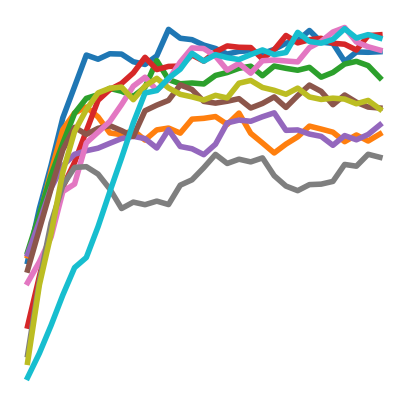

In [8]:
df = pd.read_csv(datafiles[-1][0], index_col=0)
plt.figure(figsize=(5,5))
plt.plot(df[(df[["init_cond_idx", "replicate"]]==[3,3]).all(1)][[i for i in df.columns if i[:2]=="sp"]], lw=4)
plt.axis("off")
plt.yscale("log")
plt.show()
# plt.savefig("abundace_trajectories", format="svg", bbox_inches="tight")

In [27]:
# MSPD frequency
plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(j, index_col=0)
                   for j in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.MSPD.values, 200,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
# plt.yscale("log")
plt.show()


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

<Figure size 800x500 with 0 Axes>

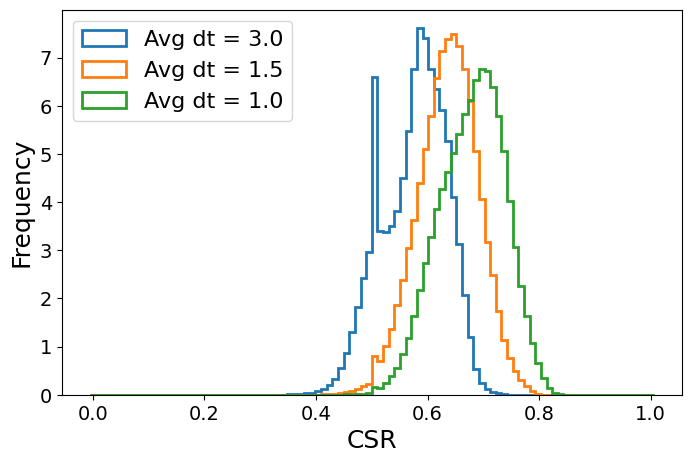

In [47]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(j, index_col=0)
                   for j in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.CSR.values, np.linspace(0, 1.01, 101)-5e-3,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


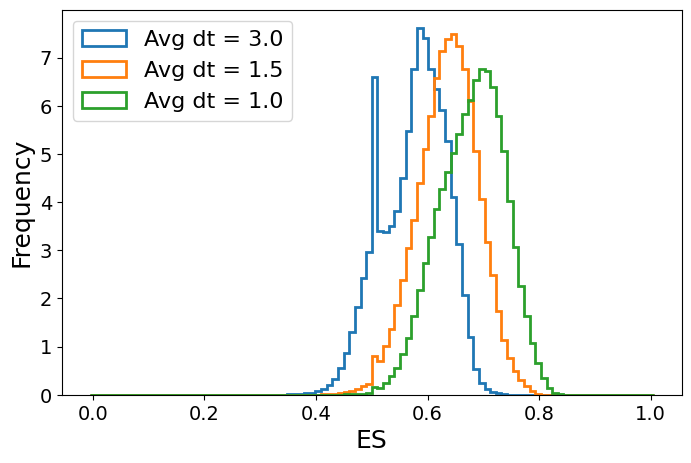

In [48]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.ES.values, np.linspace(0, 1.01, 101)-5e-3,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [49]:
# Difference between CSR and ES scores
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in inferfiles[0]], axis=0).reset_index(drop=True)
print((df.CSR != df.ES).sum())
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in inferfiles[1]], axis=0).reset_index(drop=True)
print((df.CSR != df.ES).sum())


0
0


# CSR boxplots over # of experiments
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in np.concatenate(inferfiles)], axis=0).reset_index(drop=True)
CSR = [df[df.n_dset == i]["CSR"].values for i in df.n_dset.unique()]

plt.figure(figsize=(8, 5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


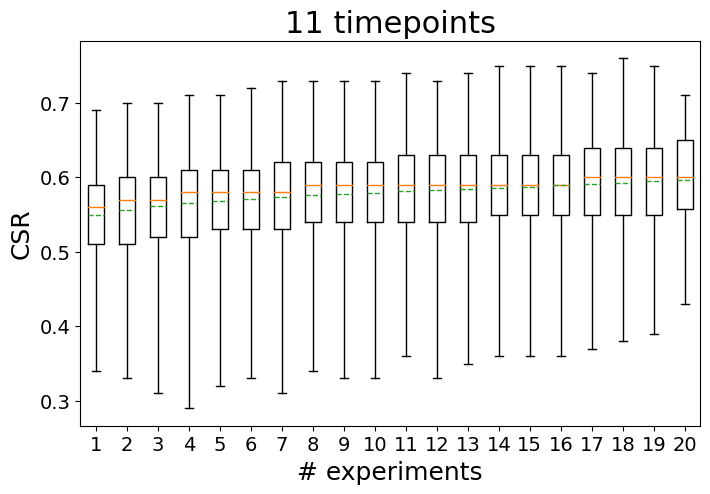

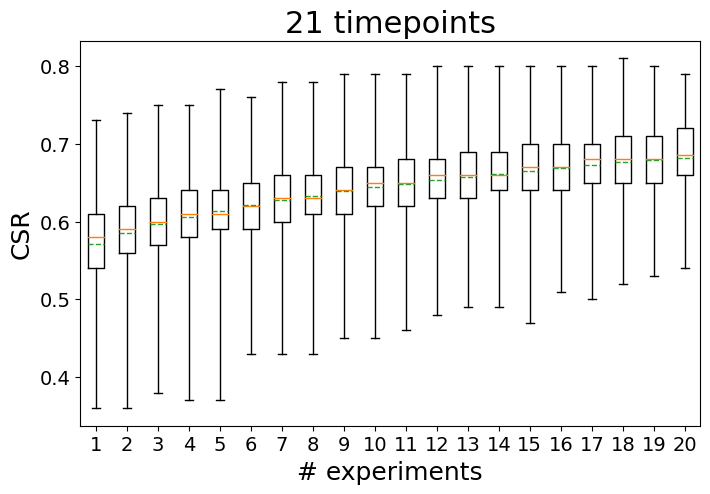

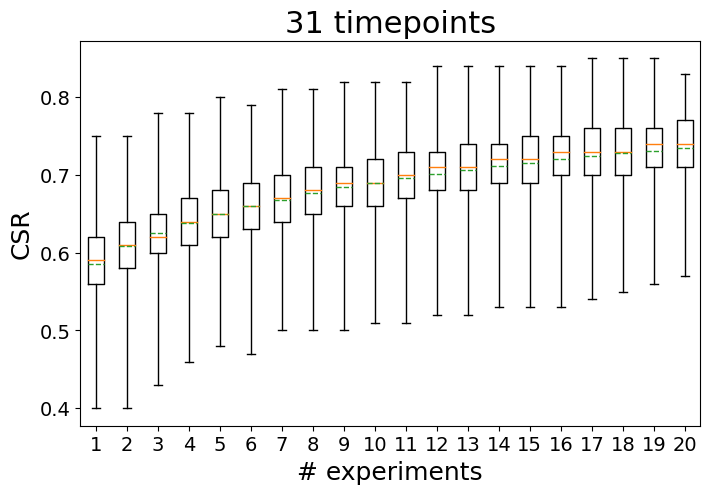

In [51]:
# CSR boxplot over # of experiments, by n_tpoints
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)

    CSR = [df[df["n_rep"] == i]
           ["CSR"].values for i in df.n_rep.unique()]

    plt.figure(figsize=(8, 5))
    plt.title(f"{log.attrs['n_samples'][i]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


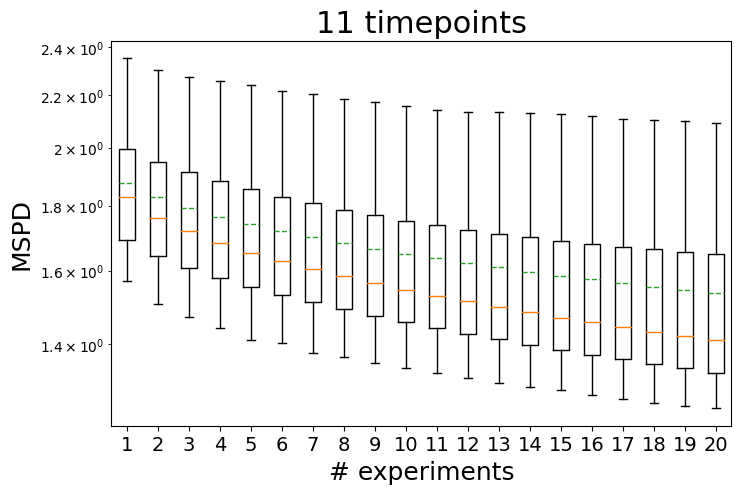

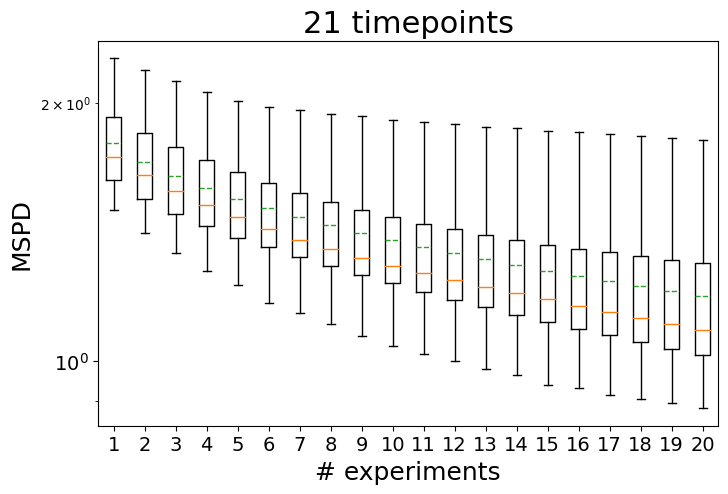

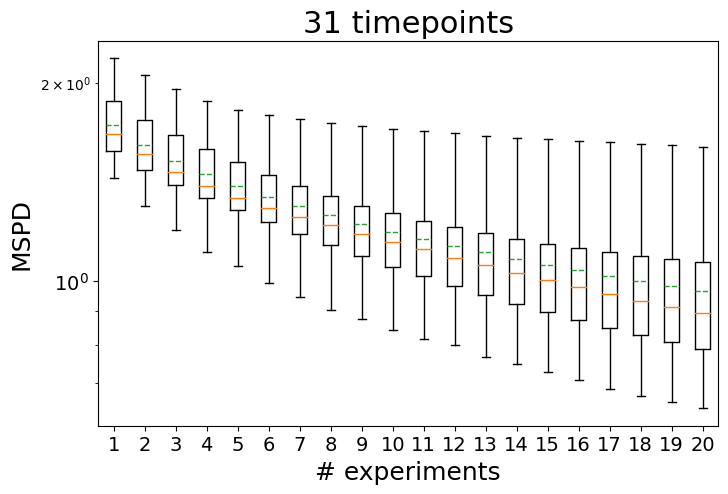

In [52]:
# CSR boxplot over # of experiments, by n_tpoints
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)

    CSR = [df[df["n_rep"] == i]
           ["MSPD"].values for i in df.n_rep.unique()]

    plt.figure(figsize=(8, 5))
    plt.title(f"{log.attrs['n_samples'][i]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("MSPD", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale("log")
    plt.show()

In [53]:
n_comb_max = 20

cdf = np.zeros((n_comb_max, 100))
pr = np.zeros((n_comb_max, 100))

a_list = []

for k in range(n_comb_max):
    a_ = []
    # a_gt_ = []
    correct_sign_ = []

    for j in range(len(inferfiles[-1])):
        df = pd.read_csv(inferfiles[-1][j], index_col=0)
        df = df[df["n_rep"]==k+1]
        p = get_meta(open(metadatafiles[-1][j], "r").read().split("\n"))["parameters"]
        # for i in tqdm(range(len(df))):
        a = df.iloc[:,15:115].values
        correct_sign = np.sign(a) == np.sign(p[10:])
        a_.append(a[:,np.array([i%11!=0 for i in range(100)])].flatten())
        # a_gt_.append(p[10:][[i%11!=0 for i in range(100)]].flatten())
        correct_sign_.append(correct_sign[:,np.array([i%11!=0 for i in range(100)])].flatten())
            
    a = np.concatenate(a_).flatten()
    # a_gt = np.concatenate(a_gt_).flatten()
    correct_sign = np.concatenate(correct_sign_).flatten()
    correct_sign = correct_sign[np.argsort(np.abs(a))]
    a = a[np.argsort(np.abs(a))]
    
    l = np.linspace(np.abs(a).min(), np.abs(a).max(), 100)

    # l = np.array([np.percentile(np.abs(a), i) for i in np.arange(0, 100, 10)])
    
    for i in tqdm(range(len(l))):
        cdf[k,i] = len(correct_sign[np.abs(a)<=l[i]])/len(correct_sign)
        pr[k,i] = correct_sign[np.abs(a)>=l[i]].mean()
        
    a_list.append(a_)
    
# a = np.concatenate(a_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 20223.26it/s]


<Figure size 640x480 with 0 Axes>

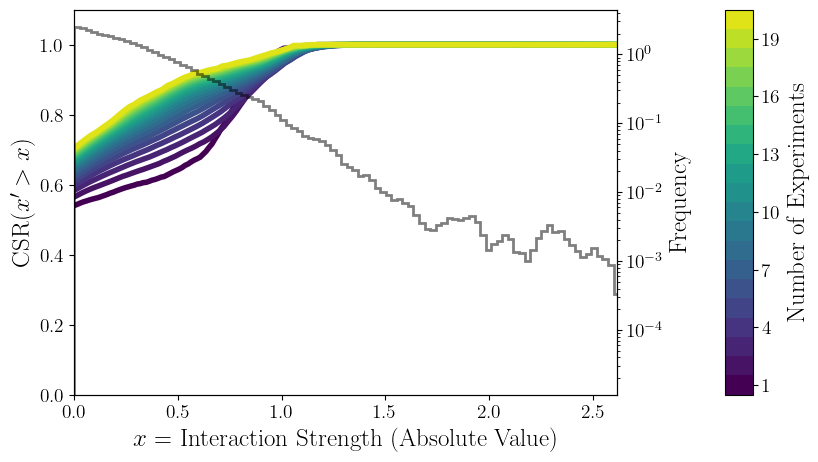

In [55]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(7, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.2, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
plt.xlim(0, np.abs(a).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("CSR($x'>x$)", fontsize=18)
ax2 = plt.gca().twinx()
# ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.hist(np.abs(np.concatenate(a_list[-5]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=18)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
# plt.plot(np.linspace(0, 3, 100), 2*np.exp(-(np.linspace(0, 3, 100)-np.concatenate(a_list[-1]).mean())**2/(2*np.concatenate(a_list[-1]).var()))/np.sqrt(2*np.pi*np.concatenate(a_list[-1]).var()), c="r")
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

<Figure size 640x480 with 0 Axes>

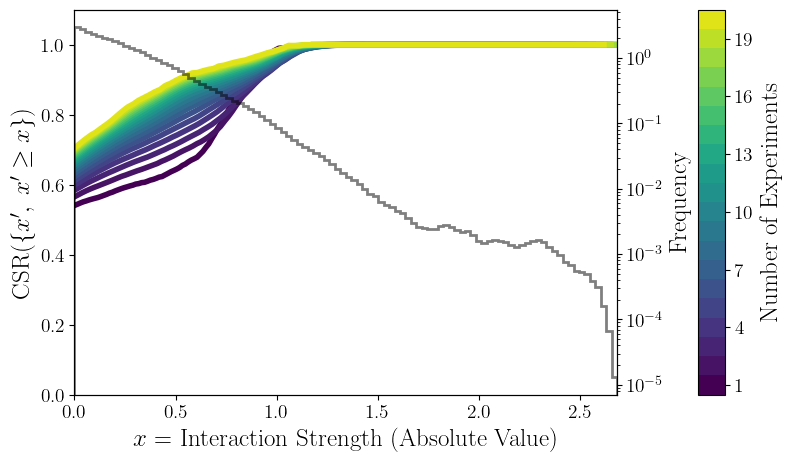

In [ ]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(7, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.15, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
plt.xlim(0, np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("CSR($\{x', \;x'\geq x\}$)", fontsize=18)
ax2 = plt.gca().twinx()
ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
# ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 10**np.linspace(-7, 0, 50), histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
# ax2.hist(np.abs(np.concatenate(a_list[-2]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=18)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
# plt.xscale("log")
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

In [ ]:
df.iloc[:,15:115].values.mean().mean()

-0.312397385686192

In [663]:
n_comb_max = 20

cdf = np.zeros((n_comb_max, 100))
pr = np.zeros((n_comb_max, 100))

a_list = []

for k in range(n_comb_max):
    a_ = []
    # a_gt_ = []
    correct_sign_ = []

    for j in range(len(inferfiles[-1])):
        df = pd.read_csv(inferfiles[-1][j], index_col=0)
        df = df[df["n_rep"]==k+1]
        p = get_meta(open(metadatafiles[-1][j], "r").read().split("\n"))["parameters"]
        # for i in tqdm(range(len(df))):
        a = df.iloc[:,15:115].values
        correct_sign = np.sign(a) == -1#np.sign(p[10:])
        a_.append(a[:,(np.sign(p[10:])==-1)*np.array([i%11!=0 for i in range(100)])].flatten())
        # a_gt_.append(p[10:][(np.sign(p[10:])==-1)*np.array([i%11!=0 for i in range(100)])].flatten())
        correct_sign_.append(correct_sign[:,(np.sign(p[10:])==-1)*np.array([i%11!=0 for i in range(100)])].flatten())
            
    a = np.concatenate(a_).flatten()
    # a_gt = np.concatenate(a_gt_).flatten()
    correct_sign = np.concatenate(correct_sign_).flatten()
    correct_sign = correct_sign[np.argsort(np.abs(a))]
    a = a[np.argsort(np.abs(a))]
    
    l = np.linspace(0., np.abs(a).max(), 100)
    # print(len(correct_sign), len(a))
    
    for i in tqdm(range(len(l))):
        cdf[k,i] = len(correct_sign[np.abs(a)<=l[i]])/len(correct_sign)
        pr[k,i] = correct_sign[np.abs(a)>=l[i]].mean()
        
    a_list.append(a_)
    
# a = np.concatenate(a_list)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 18980.47it/s]


<Figure size 640x480 with 0 Axes>

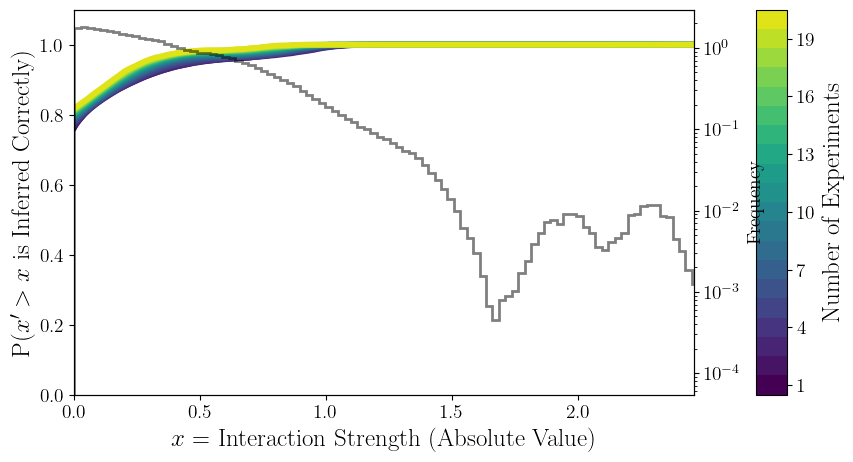

In [666]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.1, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
plt.xlim(0, np.abs(a).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("P($x'>x$ is Inferred Correctly)", fontsize=18)
ax2 = plt.gca().twinx()
# ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.hist(np.abs(np.concatenate(a_list[-5]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

<Figure size 640x480 with 0 Axes>

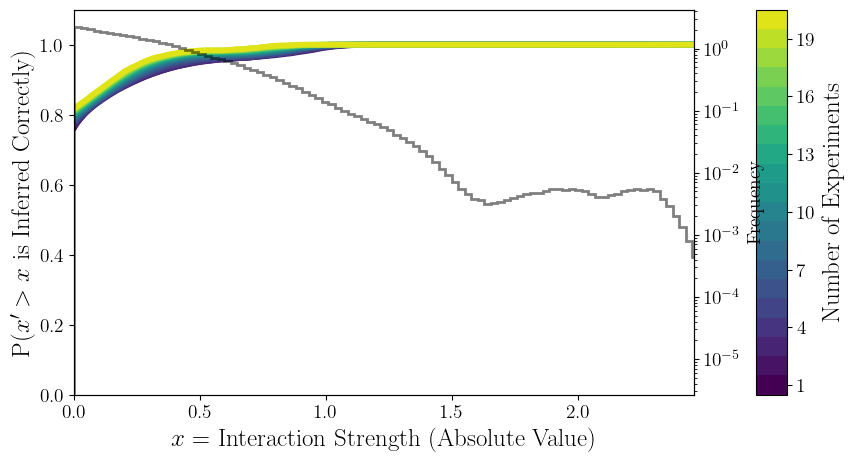

In [667]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.1, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
plt.xlim(0, np.abs(a).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("P($x'>x$ is Inferred Correctly)", fontsize=18)
ax2 = plt.gca().twinx()
ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
# ax2.hist(np.abs(np.concatenate(a_list[-2]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

In [668]:
n_comb_max = 20

cdf = np.zeros((n_comb_max, 100))
pr = np.zeros((n_comb_max, 100))

a_list = []

for k in range(n_comb_max):
    a_ = []
    # a_gt_ = []
    correct_sign_ = []

    for j in range(len(inferfiles[-1])):
        df = pd.read_csv(inferfiles[-1][j], index_col=0)
        df = df[df["n_rep"]==k+1]
        p = get_meta(open(metadatafiles[-1][j], "r").read().split("\n"))["parameters"]
        # for i in tqdm(range(len(df))):
        a = df.iloc[:,15:115].values
        correct_sign = np.sign(a) == 1#np.sign(p[10:])
        a_.append(a[:,(np.sign(p[10:])==1)*np.array([i%11!=0 for i in range(100)])].flatten())
        # a_gt_.append(p[10:][(np.sign(p[10:])==1)*np.array([i%11!=0 for i in range(100)])].flatten())
        correct_sign_.append(correct_sign[:,(np.sign(p[10:])==1)*np.array([i%11!=0 for i in range(100)])].flatten())
            
    a = np.concatenate(a_).flatten()
    # a_gt = np.concatenate(a_gt_).flatten()
    correct_sign = np.concatenate(correct_sign_).flatten()
    correct_sign = correct_sign[np.argsort(np.abs(a))]
    a = a[np.argsort(np.abs(a))]
    
    l = np.linspace(np.abs(a).min(), np.abs(a).max(), 100)
    
    for i in tqdm(range(len(l))):
        cdf[k,i] = len(correct_sign[np.abs(a)<=l[i]])/len(correct_sign)
        pr[k,i] = correct_sign[np.abs(a)>=l[i]].mean()
        
    a_list.append(a_)
    
# a = np.concatenate(a_list)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 16331.05it/s]


<Figure size 640x480 with 0 Axes>

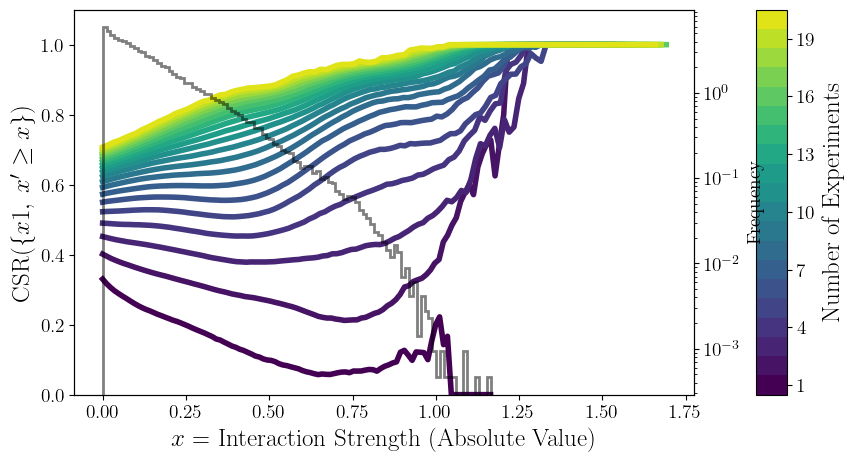

In [672]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.1, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
# plt.xlim(0, np.abs(a).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("CSR($\{x1,\;x'\geq x\}$)", fontsize=18)
ax2 = plt.gca().twinx()
# ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.hist(np.abs(np.concatenate(a_list[0]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
# plt.plot(np.linspace(0, 3, 100), 2*np.exp(-(np.linspace(0, 3, 100)-np.concatenate(a_list[-1]).mean())**2/(2*np.concatenate(a_list[-1]).var()))/np.sqrt(2*np.pi*np.concatenate(a_list[-1]).var()), c="r")
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

<Figure size 640x480 with 0 Axes>

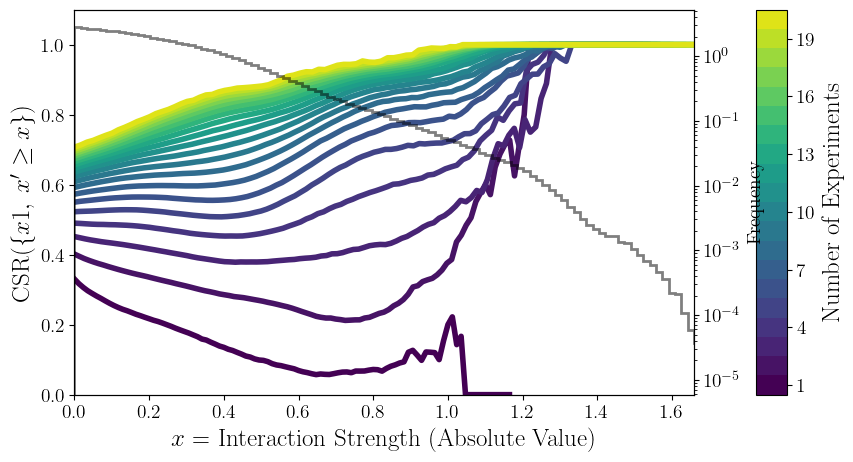

In [671]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

im = plt.contourf(pr, levels=np.arange(0.5, 21.5), cmap="viridis", vmin=1, vmax=21)
plt.clf()
# plt.subplots(1, 2, figsize=(10,5))
# plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 5))
# plt.plot(np.histogram(a))
# plt.hist(np.abs(a_gt), 10, histtype="step", lw=2, density=True, color="red")
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a)))(np.linspace(*np.sort(np.abs(np.float64(a)))[[0,-1]], 100)))
# plt.plot(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100), gaussian_kde(np.abs(np.float64(a_gt)))(np.linspace(*np.sort(np.abs(np.float64(a_gt)))[[0,-1]], 100)))
for i in range(0, pr.shape[0]):
    plt.plot(np.linspace(*np.sort(np.abs(np.concatenate(a_list[i])))[[0,-1]], 100), pr[i], lw=4, c=plt.cm.viridis(np.linspace(0, 20/21, n_comb_max))[i])
cax = plt.gca().inset_axes([1.1, 0., 0.05, 1])
cb = plt.colorbar(im, cax=cax, ticks=np.arange(1, 21, 3))
cb.ax.tick_params(labelsize=14)
cb.set_label("Number of Experiments", fontsize=18)
plt.xlim(0, np.abs(a).max())
plt.ylim(0., 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x$ = Interaction Strength (Absolute Value)", fontsize=18)
plt.ylabel("CSR($\{x1,\;x'\geq x\}$)", fontsize=18)
ax2 = plt.gca().twinx()
ax2.hist(np.abs(np.concatenate([np.concatenate(i).flatten() for i in a_list]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
# ax2.hist(np.abs(np.concatenate(a_list[-2]).flatten()), 100, histtype="step", lw=2, density=True, color="k", ls="-", alpha=0.5)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.set_yscale("log")
ax2.tick_params(labelsize=14)
# ax2.plot(np.linspace(0, 3, 100), 2*np.exp(-(np.linspace(0, 3, 100)-np.concatenate([np.concatenate(i).flatten() for i in a_list]).mean())**2/(2*np.concatenate([np.concatenate(i).flatten() for i in a_list]).var()))/np.sqrt(2*np.pi*np.concatenate([np.concatenate(i).flatten() for i in a_list]).var()), c="r")
plt.show()
# plt.subplot(1, 2, 2)
# # plt.plot(l, 1-cdf.T, lw=3)
# plt.plot(np.diff(cdf, axis=1).T, lw=3, c=plt.cm.viridis(np.linspace(0, 1, n_comb_max)))

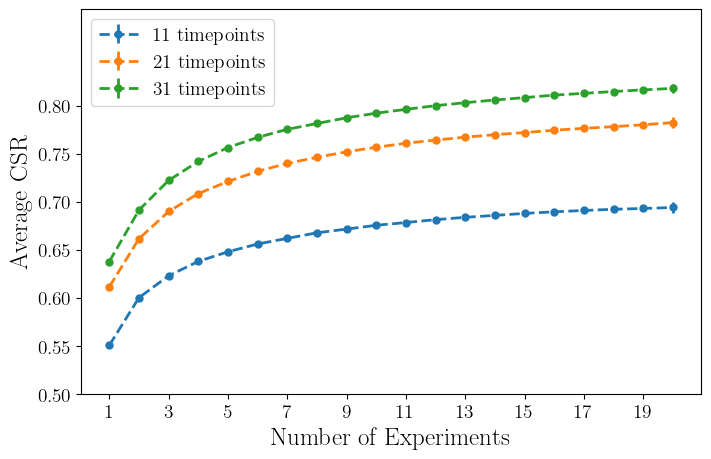

In [10]:
# average CSR over time
df = pd.concat([pd.read_csv(k, index_col=0) for k in inferfiles[0]], axis=0).reset_index(drop=True)
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
semCSR = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0)
                   for k in inferfiles[i]], axis=0).reset_index(drop=True)

    for j in range(len(df["n_rep"].unique())):
        n_rep = df["n_rep"].unique()[j]
        avgCSR[i, j] = df[df["n_rep"] ==
                          n_rep]["CSR"].values.mean()
        semCSR[i, j] = df[df["n_rep"] ==
                          n_rep]["CSR"].sem()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgCSR)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], semCSR[i], marker="o", ms=5, ls="--", lw=2, label=labels[i])
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(avgCSR[0])+1, 2), fontsize=14)
plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim(0.5, 0.9)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()
# plt.savefig("avg_csr_n_exp_rep_lr.svg", format="svg", bbox_inches="tight")

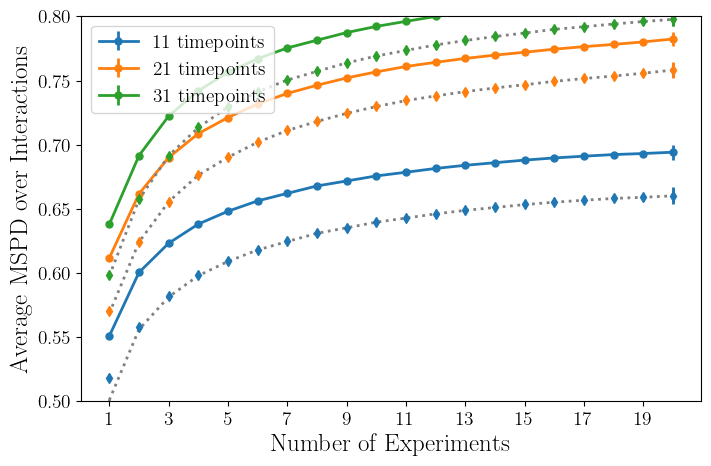

In [25]:
# average CSR over time
df = pd.concat([pd.read_csv(k, index_col=0) for k in inferfiles[0]], axis=0).reset_index(drop=True)
avgCSR_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
semCSR_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
for i in range(len(log.attrs["avg_samp_dt"])):
    df_list = []
    for k in range(len(inferfiles[i])):
        df_tmp = pd.read_csv(inferfiles[i][k], index_col=0)
        p = get_meta(open(metadatafiles[i][k], "r").read().split("\n"))["parameters"]
        df_tmp["CSR_int"] = (np.sign(df_tmp.iloc[:,15:115])==np.sign(p[10:])).iloc[:,[j%11!=0 for j in range(100)]].mean(1)
        df_list.append(df_tmp)

    df = pd.concat(df_list, axis=0).reset_index(drop=True)

    for j in range(len(df["n_rep"].unique())):
        n_rep = df["n_rep"].unique()[j]
        avgCSR_non_diag[i, j] = df[df["n_rep"] ==
                          n_rep]["CSR_int"].values.mean()
        semCSR_non_diag[i, j] = df[df["n_rep"] ==
                          n_rep]["CSR_int"].sem()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))

for i in range(len(avgCSR)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], semCSR[i], marker="o", ms=5, lw=2, label=labels[i])
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)

plt.legend(loc="upper left", fontsize=14)
for i in range(len(avgCSR)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR[i])+1),
             (avgCSR[i]*100-10)/90, semCSR[i], marker="", ms=5, lw=2, ls="dotted", c="gray", label="a")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)

for i in range(len(avgCSR_non_diag)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR_non_diag[i])+1),
             avgCSR_non_diag[i], semCSR_non_diag[i], marker="d", ms=5, lw=2, ls="", c=f"C{i}")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
# ax2 = plt.gca().twinx()
# ax2.legend(loc="lower right", fontsize=14)
# for i in range(3):
#     leg2.texts[i].set_visible(False)
# plt.gca().add_artist(leg1)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average MSPD over Interactions", fontsize=18)
plt.xticks(np.arange(1, len(avgCSR_non_diag[0])+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
plt.show()
# plt.savefig("avg_csr_n_exp_rep.svg", format="svg", bbox_inches="tight")

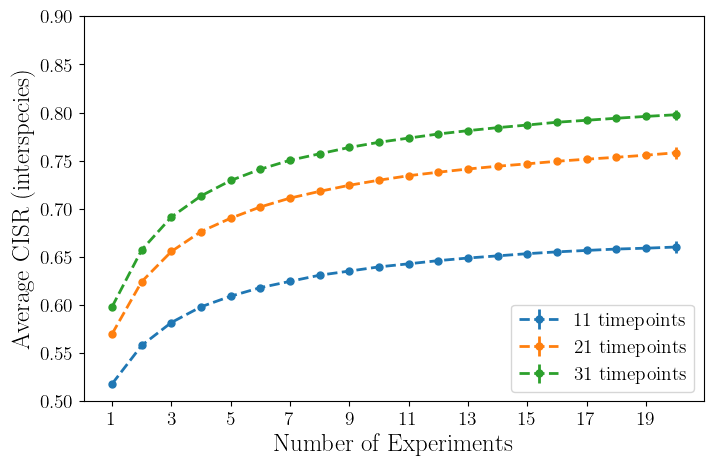

In [26]:
# average CSR over time

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))

for i in range(len(avgCSR_non_diag)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR_non_diag[i])+1),
             avgCSR_non_diag[i], semCSR_non_diag[i], marker="o", ms=5, ls="--", lw=2, label=labels[i])
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
# ax2 = plt.gca().twinx()
# ax2.legend(loc="lower right", fontsize=14)
# for i in range(3):
#     leg2.texts[i].set_visible(False)
# plt.gca().add_artist(leg1)
plt.legend(loc=("lower right"), fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average CISR (interspecies)", fontsize=18)
plt.xticks(np.arange(1, len(avgCSR_non_diag[0])+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.5, 0.9)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
# plt.show()
plt.savefig("avg_csr_n_exp_rep_lr_non_diag.svg", format="svg", bbox_inches="tight")

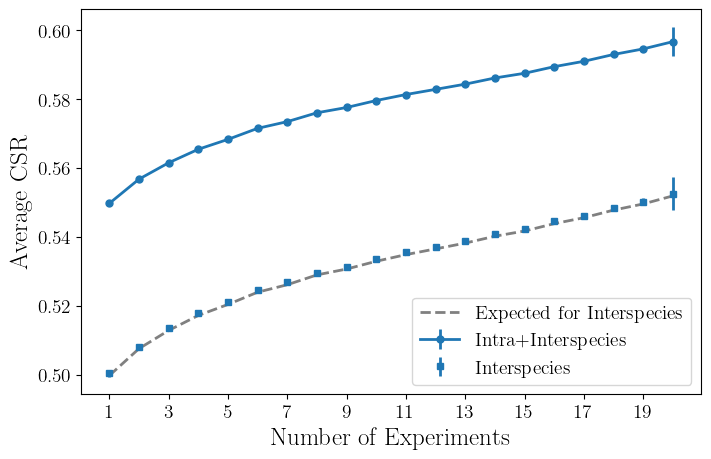

In [66]:
# average CSR over time

# avgCSR_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# semCSR_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# for i in range(len(log.attrs["avg_samp_dt"])):
#     df_list = []
#     for k in range(len(inferfiles[i])):
#         df_tmp = pd.read_csv(inferfiles[i][k], index_col=0)
#         p = get_meta(open(metadatafiles[i][k], "r").read().split("\n"))["parameters"]
#         df_tmp["CSR_int"] = (np.sign(df_tmp.iloc[:,15:115])==np.sign(p[10:])).iloc[:,[j%11!=0 for j in range(100)]].mean(1)
#         df_list.append(df_tmp)

#     df = pd.concat(df_list, axis=0).reset_index(drop=True)

#     for j in range(len(df["n_rep"].unique())):
#         n_rep = df["n_rep"].unique()[j]
#         avgCSR_non_diag[i, j] = df[df["n_rep"] ==
#                           n_rep]["CSR_int"].values.mean()
#         semCSR_non_diag[i, j] = df[df["n_rep"] ==
#                           n_rep]["CSR_int"].sem()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))

for i in range(1):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], semCSR[i], marker="o", ms=5, lw=2, label="Intra+Interspecies")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)

# plt.legend(loc="upper left", fontsize=14)
for i in range(1):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.plot(np.arange(1, len(avgCSR[i])+1),
             (avgCSR[i]*100-10)/90, marker="", ms=5, lw=2, ls="--", c="gray", label="Expected for Interspecies")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)

for i in range(1):
    plt.errorbar(np.arange(1, len(avgCSR_non_diag[i])+1),
         avgCSR_non_diag[i], semCSR_non_diag[i], marker="s", ms=5, lw=2, ls="", c=f"C{i}", label="Interspecies")
    
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(avgCSR_non_diag[0])+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
plt.show()
# plt.savefig("avg_csr_n_exp_rep.svg", format="svg", bbox_inches="tight")

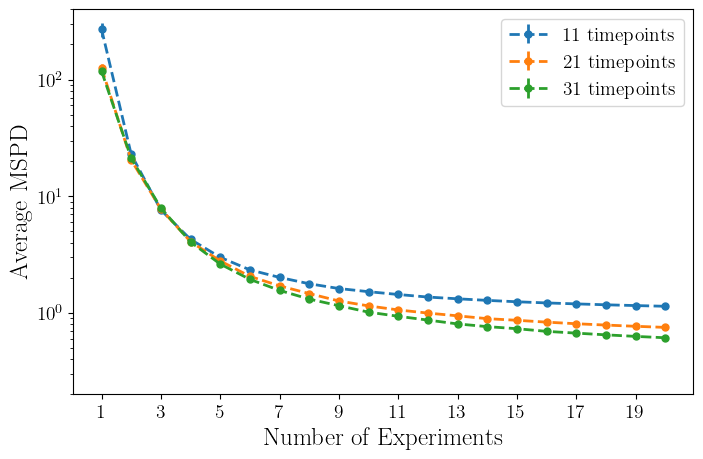

In [40]:
# average CSR over time
# df = pd.concat([pd.read_csv(k, index_col=0) for k in inferfiles[0]], axis=0).reset_index(drop=True)
# avgMSPD = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# semMSPD = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# for i in range(len(log.attrs["avg_samp_dt"])):
#     df = pd.concat([pd.read_csv(k, index_col=0)
#                    for k in inferfiles[i]], axis=0).reset_index(drop=True)

#     for j in range(len(df["n_rep"].unique())):
#         n_rep = df["n_rep"].unique()[j]
#         avgMSPD[i, j] = df[df["n_rep"] ==
#                           n_rep]["MSPD"].values.mean()
#         semMSPD[i, j] = df[df["n_rep"] ==
#                           n_rep]["MSPD"].sem()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgMSPD)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgMSPD[i])+1),
             avgMSPD[i], semMSPD[i], marker="o", ms=5, ls="--", lw=2, label=labels[i])
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average MSPD", fontsize=18)
plt.xticks(np.arange(1, len(avgMSPD[0])+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
# plt.show()
# plt.ylim(1e-1, 4)
# plt.savefig("avg_mspd_n_exp_rep_lr.svg", format="svg", bbox_inches="tight")
# plt.savefig("avg_mspd_n_exp_rep_lr_zoom.svg", format="svg", bbox_inches="tight")

plt.yscale("log")
plt.ylim(2e-1, 4e2)
plt.savefig("avg_mspd_log_n_exp_rep_lr.svg", format="svg", bbox_inches="tight")

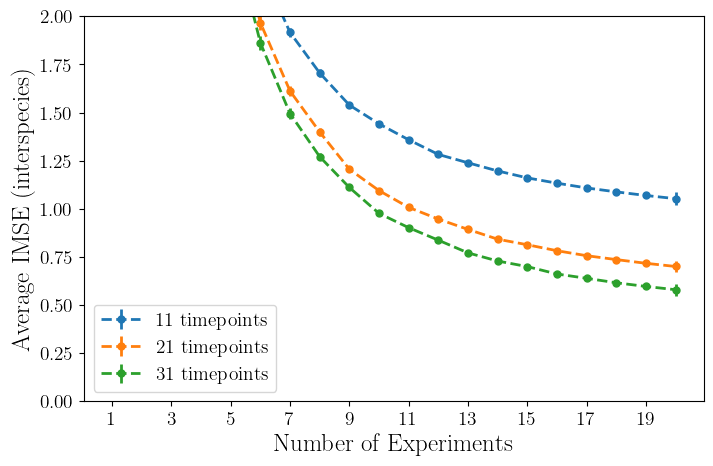

In [22]:
# average CSR over time
# avgMSPD_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# semMSPD_non_diag = np.zeros((len(log.attrs["avg_samp_dt"]), len(df["n_rep"].unique())))
# for i in range(len(log.attrs["avg_samp_dt"])):
#     df_list = []
#     for k in range(len(inferfiles[i])):
#         df_tmp = pd.read_csv(inferfiles[i][k], index_col=0)
#         p = get_meta(open(metadatafiles[i][k], "r").read().split("\n"))["parameters"]
#         df_tmp["MSPD_int"] = (((df_tmp.iloc[:,15:115]-p[10:]))**2).iloc[:,[j%11!=0 for j in range(100)]].mean(1)
#         df_list.append(df_tmp)

#     df = pd.concat(df_list, axis=0).reset_index(drop=True)

#     for j in range(len(df["n_rep"].unique())):
#         n_rep = df["n_rep"].unique()[j]
#         avgMSPD_non_diag[i, j] = df[df["n_rep"] ==
#                           n_rep]["MSPD_int"].values.mean()
#         semMSPD_non_diag[i, j] = df[df["n_rep"] ==
#                           n_rep]["MSPD_int"].sem()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgMSPD_non_diag)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
    plt.errorbar(np.arange(1, len(avgMSPD_non_diag[i])+1),
             avgMSPD_non_diag[i], semMSPD_non_diag[i], marker="o", ms=5, ls="--", lw=2, label=labels[i])
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
plt.legend(loc="lower left", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average IMSE (interspecies)", fontsize=18)
plt.xticks(np.arange(1, len(avgMSPD_non_diag[0])+1, 2), fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.ylim(0, 2)
plt.savefig("avg_mspd_n_exp_rep_lr_non_diag.svg", format="svg", bbox_inches="tight")

# plt.yscale("log")
# plt.ylim(1e-1, 5e2)
# plt.savefig("avg_mspd_log_n_exp_rep_lr_non_diag.svg", format="svg", bbox_inches="tight")

In [44]:
import warnings

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [45]:
def avg_mspd(x, axis):
    if x.shape[axis] > 0:
        return x.mean(axis)
    else:
        return 0.

def corr_sign_prop(x, axis):
    if x.shape[axis] > 0:
        return x.mean(axis)
    else:
        return 1.

In [46]:
A_mspd = []
A_m_mspd = []
A_p_mspd = []
A_mm_mspd = []
A_pm_mspd = []
A_pp_mspd = []

A_m_corr_prop = []
A_p_corr_prop = []
A_mm_corr_prop = []
A_pm_corr_prop = []
A_pp_corr_prop = []

A_single_corr_prop = []
A_pair_corr_prop = []

df_list = []

for k in tqdm(range(len(inferfiles[-1]))):   
    df = pd.read_csv(inferfiles[-1][k], index_col=0)
    
    # df.iloc[:,5:115] = -1.

    p = get_meta(open(metadatafiles[-1][k], "r").read().split("\n"))["parameters"]
    A = p[10:].reshape((10,10))
    # A = -np.ones((10,10))
    non_diag_idx = np.array([i%11!=0 for i in range(100)])
    A_m_idx = (np.sign(p[10:])==-1)*np.array([i%11!=0 for i in range(100)])
    A_p_idx = (np.sign(p[10:])==1)*np.array([i%11!=0 for i in range(100)])
    A_mm_idx = (np.sign(A)+np.sign(A.T)==-2).flatten()*np.array([i%11!=0 for i in range(100)])
    A_pm_idx = (np.sign(A)+np.sign(A.T)==0).flatten()*np.array([i%11!=0 for i in range(100)])
    # A_pm_idx = ((np.sign(A)==1)*(np.sign(A).T==-1)).flatten()*np.array([i%11!=0 for i in range(100)])
    # A_mp_idx = ((np.sign(A)==-1)*(np.sign(A).T==1)).flatten()*np.array([i%11!=0 for i in range(100)])
    A_pp_idx = (np.sign(A)+np.sign(A.T)==2).flatten()*np.array([i%11!=0 for i in range(100)])
    
    mspd = (df.iloc[:,15:115].values-p[10:])**2
    
    df["n_A_m"] = A_m_idx.sum()
    df["n_A_p"] = A_p_idx.sum()
    df["n_A_mm"] = A_mm_idx.sum()
    df["n_A_pm"] = A_pm_idx.sum()
    df["n_A_pp"] = A_pp_idx.sum()
    
    df["A_mspd"] = avg_mspd(mspd[:,non_diag_idx], 1)
    df["A_m_mspd"] = avg_mspd(mspd[:,A_m_idx], 1)
    df["A_p_mspd"] = avg_mspd(mspd[:,A_p_idx], 1)
    
    df["A_mm_mspd"] = avg_mspd(mspd[:,A_mm_idx], 1)
    df["A_pm_mspd"] = avg_mspd(mspd[:,A_pm_idx], 1)
    df["A_pp_mspd"] = avg_mspd(mspd[:,A_pp_idx], 1)
    
    df["A_single_corr_prop"] = corr_sign_prop((np.sign(df.iloc[:,15:115])==np.sign(A.flatten())).values[:,non_diag_idx], 1)
    df["A_m_corr_prop"] = corr_sign_prop((np.sign(df.iloc[:,15:115].values)==-1)[:,A_m_idx], 1)
    df["A_p_corr_prop"] = corr_sign_prop((np.sign(df.iloc[:,15:115].values[:,A_p_idx])==1), 1)
    
    corr_sign = (np.sign(df.iloc[:,15:115].values)==np.sign(A.flatten())).reshape((len(df), 10, 10))
    
    df["A_pair_corr_prop"] = corr_sign_prop((corr_sign*corr_sign.transpose((0,2,1))).reshape((len(df), 100))[:,non_diag_idx], 1)
    df["A_mm_corr_prop"] = corr_sign_prop((corr_sign*corr_sign.transpose((0,2,1))).reshape((len(df), 100))[:,A_mm_idx], 1)
    df["A_pm_corr_prop"] = corr_sign_prop((corr_sign*corr_sign.transpose((0,2,1))).reshape((len(df), 100))[:,A_pm_idx], 1)
    df["A_pp_corr_prop"] = corr_sign_prop((corr_sign*corr_sign.transpose((0,2,1))).reshape((len(df), 100))[:,A_pp_idx], 1)
    
    df_list.append(df)

df = pd.concat(df_list, axis=0).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


In [47]:
def wmean(x, w):
    return (w*x).sum()/w.sum()

def wsem(x, w):
    m = wmean(x, w)
    s = (w*(x-m)**2).sum()/(w.sum()*(w.sum()-1))
    
    return s**0.5

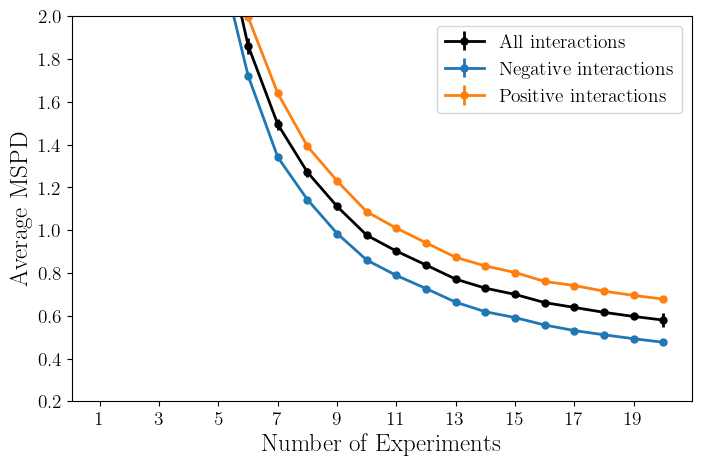

In [70]:
avgA_mspd = np.zeros(len(df["n_rep"].unique()))
semA_mspd = np.zeros(len(df["n_rep"].unique()))
avgA_m_mspd = np.zeros(len(df["n_rep"].unique()))
semA_m_mspd = np.zeros(len(df["n_rep"].unique()))
avgA_p_mspd = np.zeros(len(df["n_rep"].unique()))
semA_p_mspd = np.zeros(len(df["n_rep"].unique()))

for j in range(len(df["n_rep"].unique())):
    n_rep = df["n_rep"].unique()[j]
    
    avgA_mspd[j] = df[df["n_rep"]==n_rep]["A_mspd"].values.mean()
    semA_mspd[j] = df[df["n_rep"]==n_rep]["A_mspd"].sem()
    
    avgA_m_mspd[j] = wmean(df[df["n_rep"]==n_rep]["A_m_mspd"].values, df[df["n_rep"]==n_rep]["n_A_m"].values)
    semA_m_mspd[j] = wsem(df[df["n_rep"]==n_rep]["A_m_mspd"].values, df[df["n_rep"]==n_rep]["n_A_m"].values)
    
    avgA_p_mspd[j] = wmean(df[df["n_rep"]==n_rep]["A_p_mspd"].values, df[df["n_rep"]==n_rep]["n_A_p"].values)
    semA_p_mspd[j] = wsem(df[df["n_rep"]==n_rep]["A_p_mspd"].values, df[df["n_rep"]==n_rep]["n_A_p"].values)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(1, len(avgA_m_mspd)+1),
         avgA_mspd, semA_mspd, marker="o", ms=5, lw=2, label="All interactions", c="k")
plt.errorbar(np.arange(1, len(avgA_m_mspd)+1),
         avgA_m_mspd, semA_m_mspd, marker="o", ms=5, lw=2, label="Negative interactions")
plt.errorbar(np.arange(1, len(avgA_m_mspd)+1),
         avgA_p_mspd, semA_p_mspd, marker="o", ms=5, lw=2, label="Positive interactions")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average MSPD", fontsize=18)
plt.xticks(np.arange(1, len(avgA_m_mspd)+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")

# plt.show()
# plt.savefig("avg_mspd_n_exp_rep.svg", format="svg", bbox_inches="tight")

plt.ylim(2e-1, 2)
# plt.show()
# plt.yscale("log")
plt.savefig("avg_mspd_n_exp_rep_lr_int_sign.svg", format="svg", bbox_inches="tight")

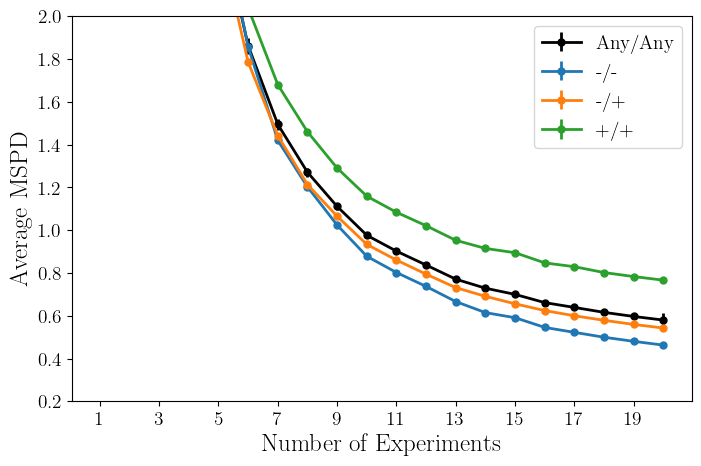

In [69]:
# average CSR over time
avgA_mm_mspd = np.zeros(len(df["n_rep"].unique()))
semA_mm_mspd = np.zeros(len(df["n_rep"].unique()))
avgA_pm_mspd = np.zeros(len(df["n_rep"].unique()))
semA_pm_mspd = np.zeros(len(df["n_rep"].unique()))
avgA_pp_mspd = np.zeros(len(df["n_rep"].unique()))
semA_pp_mspd = np.zeros(len(df["n_rep"].unique()))

for j in range(len(df["n_rep"].unique())):
    n_rep = df["n_rep"].unique()[j]
    
    avgA_mm_mspd[j] = wmean(df[df["n_rep"]==n_rep]["A_mm_mspd"].values, df[df["n_rep"]==n_rep]["n_A_mm"].values)
    semA_mm_mspd[j] = wsem(df[df["n_rep"]==n_rep]["A_mm_mspd"].values, df[df["n_rep"]==n_rep]["n_A_mm"].values)
    
    avgA_pm_mspd[j] = wmean(df[df["n_rep"]==n_rep]["A_pm_mspd"].values, df[df["n_rep"]==n_rep]["n_A_pm"].values)
    semA_pm_mspd[j] = wsem(df[df["n_rep"]==n_rep]["A_pm_mspd"].values, df[df["n_rep"]==n_rep]["n_A_pm"].values)
    
    avgA_pp_mspd[j] = wmean(df[df["n_rep"]==n_rep]["A_pp_mspd"].values, df[df["n_rep"]==n_rep]["n_A_pp"].values)
    semA_pp_mspd[j] = wsem(df[df["n_rep"]==n_rep]["A_pp_mspd"].values, df[df["n_rep"]==n_rep]["n_A_pp"].values)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(1, len(avgA_mm_mspd)+1),
         avgA_mspd, semA_mspd, marker="o", ms=5, lw=2, label="Any/Any", c="k")
plt.errorbar(np.arange(1, len(avgA_mm_mspd)+1),
         avgA_mm_mspd, semA_mm_mspd, marker="o", ms=5, lw=2, label="-/-")
plt.errorbar(np.arange(1, len(avgA_mm_mspd)+1),
         avgA_pm_mspd, semA_pm_mspd, marker="o", ms=5, lw=2, label="-/+")
plt.errorbar(np.arange(1, len(avgA_mm_mspd)+1),
         avgA_pp_mspd, semA_pp_mspd, marker="o", ms=5, lw=2, label="+/+")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average MSPD", fontsize=18)
plt.xticks(np.arange(1, len(avgA_m_mspd)+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
plt.ylim(2e-1, 2)
# plt.show()
plt.savefig("avg_mspd_n_exp_rep_lr_pair_sign.svg", format="svg", bbox_inches="tight")

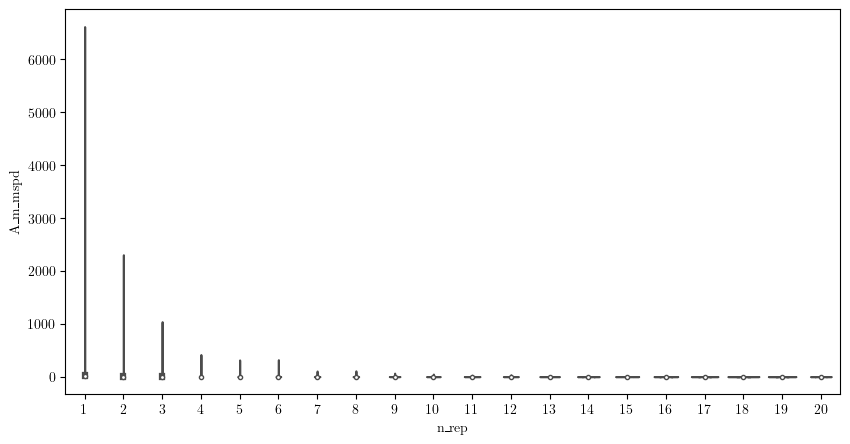

In [53]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.violinplot(df, x="n_rep", y="A_m_mspd", split=True, color="blue", scale="area", cut=0)
plt.show()

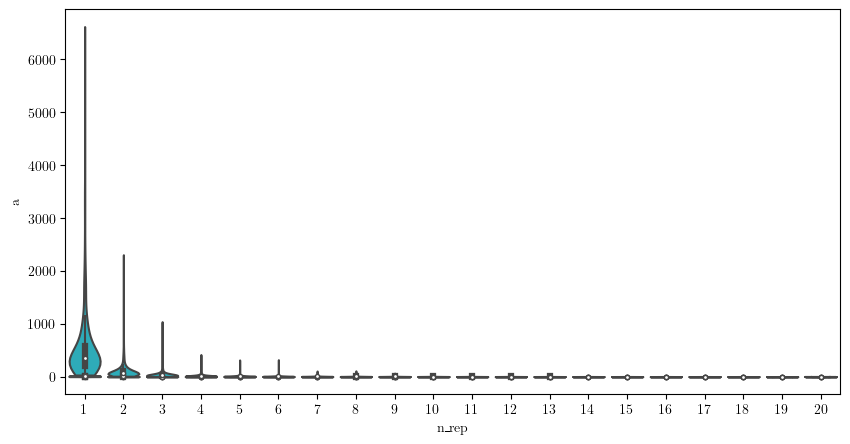

In [54]:
import seaborn as sns

plt.figure(figsize=(10,5))
for i in range(1, 10, 2):
    sns.violinplot(df[int(len(df)*i/10):int(len(df)*(i+1)/10)], x="n_rep", y="A_m_mspd", scale="width", color=f"C{i}", cut=0, bw=0.3)
    # sns.stripplot(df[int(len(df)*i/10):int(len(df)*(i+1)/10)], x="n_rep", y="A_m_mspd", color=f"C{i}", alpha=0.1)
plt.ylabel("a")
plt.show()
# sns.violinplot(df[int(len(df)*9/10):], x="n_rep", y="A_pm_mspd", split=True, color="red", scale="width")
# sns.violinplot(df[int(len(df)*9/10):], x="n_rep", y="A_pp_mspd", split=True, color="orange", scale="width")

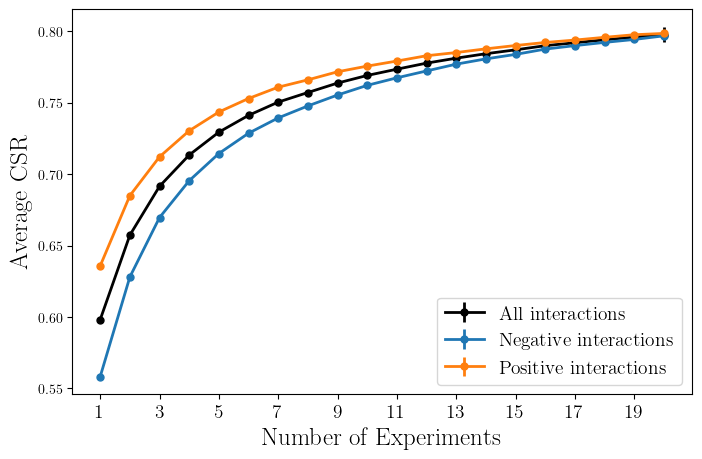

In [73]:
# average CSR over time
avgA_single_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_single_corr_prop = np.zeros(len(df["n_rep"].unique()))
avgA_m_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_m_corr_prop = np.zeros(len(df["n_rep"].unique()))
avgA_p_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_p_corr_prop = np.zeros(len(df["n_rep"].unique()))

for j in range(len(df["n_rep"].unique())):
    n_rep = df["n_rep"].unique()[j]
    
    avgA_single_corr_prop[j] = df[df["n_rep"] ==
                      n_rep]["A_single_corr_prop"].values.mean()
    semA_single_corr_prop[j] = df[df["n_rep"] ==
                      n_rep]["A_single_corr_prop"].sem()
    
    avgA_m_corr_prop[j] = wmean(df[df["n_rep"]==n_rep]["A_m_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_m"].values)
    semA_m_corr_prop[j] = wsem(df[df["n_rep"]==n_rep]["A_m_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_m"].values)
    
    avgA_p_corr_prop[j] = wmean(df[df["n_rep"]==n_rep]["A_p_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_p"].values)
    semA_p_corr_prop[j] = wsem(df[df["n_rep"]==n_rep]["A_p_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_p"].values)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
# for i in range(len(avgRMSPD)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_single_corr_prop, semA_single_corr_prop, marker="o", ms=5, lw=2, label="All interactions", c="k")
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_m_corr_prop, semA_m_corr_prop, marker="o", ms=5, lw=2, label="Negative interactions")
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_p_corr_prop, semA_p_corr_prop, marker="o", ms=5, lw=2, label="Positive interactions")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(avgA_m_mspd)+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
# plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
# plt.show()
plt.savefig("avg_csr_n_exp_rep_lr_int_sign.svg", format="svg", bbox_inches="tight")

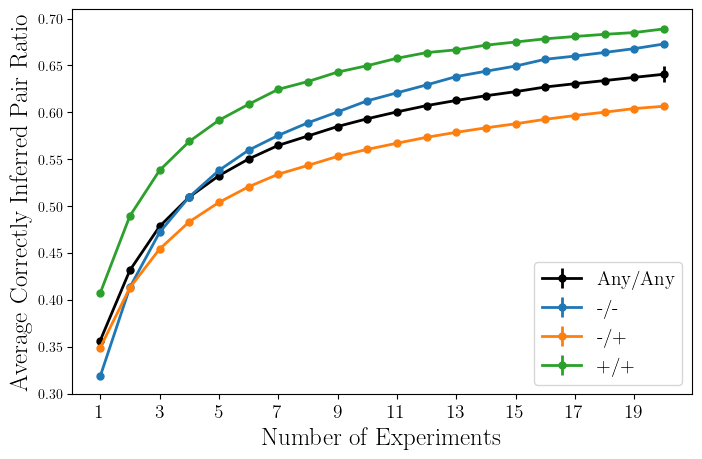

In [76]:
# average CSR over time
avgA_pair_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_pair_corr_prop = np.zeros(len(df["n_rep"].unique()))
avgA_mm_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_mm_corr_prop = np.zeros(len(df["n_rep"].unique()))
avgA_pm_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_pm_corr_prop = np.zeros(len(df["n_rep"].unique()))
avgA_pp_corr_prop = np.zeros(len(df["n_rep"].unique()))
semA_pp_corr_prop = np.zeros(len(df["n_rep"].unique()))

for j in range(len(df["n_rep"].unique())):
    n_rep = df["n_rep"].unique()[j]
    avgA_pair_corr_prop[j] = df[df["n_rep"] ==
                      n_rep]["A_pair_corr_prop"].values.mean()
    semA_pair_corr_prop[j] = df[df["n_rep"] ==
                      n_rep]["A_pair_corr_prop"].sem()
    
    avgA_mm_corr_prop[j] = wmean(df[df["n_rep"]==n_rep]["A_mm_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_mm"].values)
    semA_mm_corr_prop[j] = wsem(df[df["n_rep"]==n_rep]["A_mm_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_mm"].values)
    
    avgA_pm_corr_prop[j] = wmean(df[df["n_rep"]==n_rep]["A_pm_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_pm"].values)
    semA_pm_corr_prop[j] = wsem(df[df["n_rep"]==n_rep]["A_pm_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_pm"].values)
    
    avgA_pp_corr_prop[j] = wmean(df[df["n_rep"]==n_rep]["A_pp_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_pp"].values)
    semA_pp_corr_prop[j] = wsem(df[df["n_rep"]==n_rep]["A_pp_corr_prop"].values, df[df["n_rep"]==n_rep]["n_A_pp"].values)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})
        
labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
# for i in range(len(avgRMSPD)):
    # plt.plot(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i], "-o", lw=2, ms=5, label=labels[i])
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_pair_corr_prop, semA_pair_corr_prop, marker="o", ms=5, lw=2, label="Any/Any", c="k")
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_mm_corr_prop, semA_mm_corr_prop, marker="o", ms=5, lw=2, label="-/-")
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_pm_corr_prop, semA_pm_corr_prop, marker="o", ms=5, lw=2, label="-/+")
plt.errorbar(np.arange(1, len(avgA_m_corr_prop)+1),
         avgA_pp_corr_prop, semA_pp_corr_prop, marker="o", ms=5, lw=2, label="+/+")
    # plt.fill_between(np.arange(1, len(avgCSR[i])+1),
    #          avgCSR[i]-semCSR[i], avgCSR[i]+semCSR[i], alpha=0.5)
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("Number of Experiments", fontsize=18)
plt.ylabel("Average Correctly Inferred Pair Ratio", fontsize=18)
plt.xticks(np.arange(1, len(avgA_m_mspd)+1, 2), fontsize=14)
# plt.yticks(np.arange(0.5, 0.8, 0.05), fontsize=14)
# plt.yticks(fontsize=14)
# plt.ylim(0.5, 0.8)
# for i in range(1, len(avgCSR[0]), 6):
#     plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="dotted")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.yscale("log")
# plt.show()
plt.savefig("avg_csr_n_exp_rep_lr_pair_sign.svg", format="svg", bbox_inches="tight")

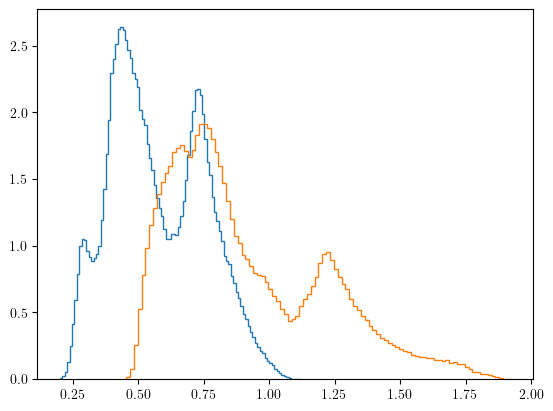

In [153]:
plt.hist(A_m_mspd, 100, histtype="step", density=True)
plt.hist(A_p_mspd, 100, histtype="step", density=True)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

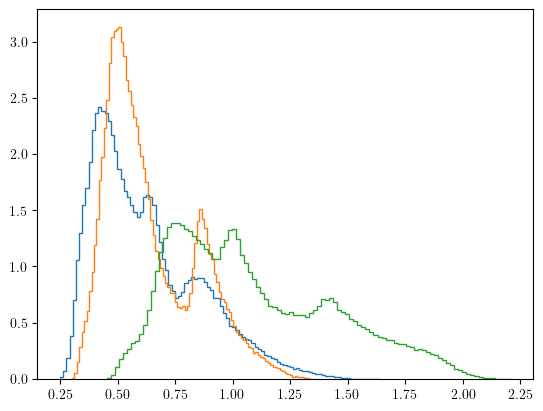

In [132]:
plt.hist(A_mm_mspd, 100, histtype="step", density=True)
plt.hist(A_pm_mspd, 100, histtype="step", density=True)
plt.hist(A_pp_mspd, 100, histtype="step", density=True)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

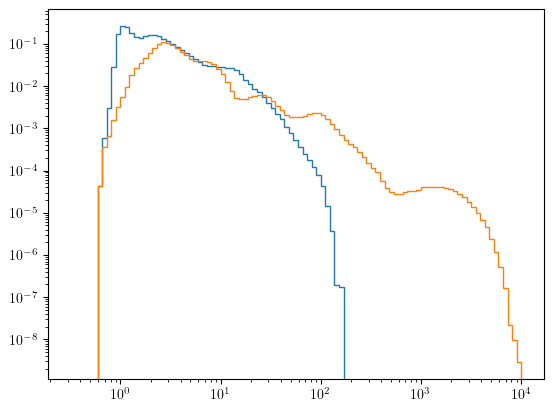

In [136]:
plt.hist(A_m_rmspd, 10**np.linspace(-0.5, 4, 100), histtype="step", density=True)
plt.hist(A_p_rmspd, 10**np.linspace(-0.5, 4, 100), histtype="step", density=True)
plt.xscale("log")
plt.yscale("log")
plt.show()

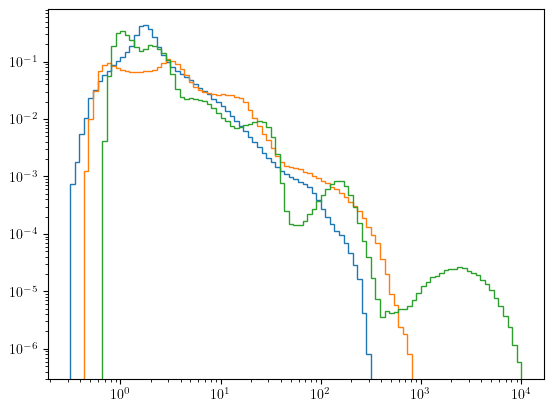

In [139]:
plt.hist(A_mm_rmspd, 10**np.linspace(-0.5, 4, 100), histtype="step", density=True)
plt.hist(A_pm_rmspd, 10**np.linspace(-0.5, 4, 100), histtype="step", density=True)
plt.hist(A_pp_rmspd, 10**np.linspace(-0.5, 4, 100), histtype="step", density=True)
plt.xscale("log")
plt.yscale("log")
plt.show()

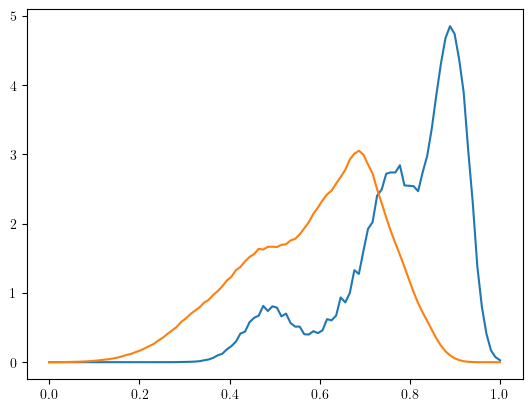

In [19]:
from scipy.stats import gaussian_kde

plt.plot(np.linspace(0, 1, 100), gaussian_kde(A_m_corr_prop)(np.linspace(0, 1, 100)))
plt.plot(np.linspace(0, 1, 100), gaussian_kde(A_p_corr_prop)(np.linspace(0, 1, 100)))

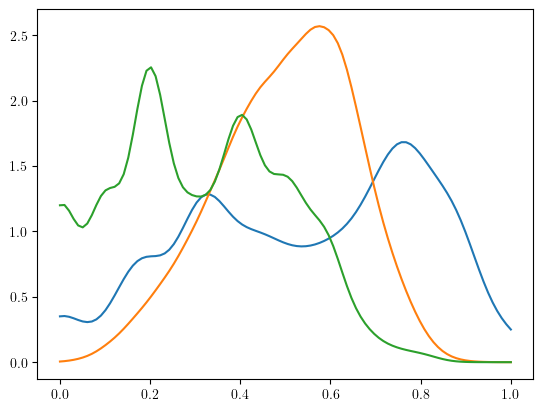

In [20]:
plt.plot(np.linspace(0, 1, 100), gaussian_kde(A_mm_corr_prop, bw_method=0.2)(np.linspace(0, 1, 100)))
plt.plot(np.linspace(0, 1, 100), gaussian_kde(A_pm_corr_prop, bw_method=0.2)(np.linspace(0, 1, 100)))
plt.plot(np.linspace(0, 1, 100), gaussian_kde(A_pp_corr_prop, bw_method=0.2)(np.linspace(0, 1, 100)))
plt.show()

In [185]:
def dot_mean(m):
    avg_cos = 0
    avg_norm_prod = 0
    n = 0
    for i in range(len(m)-1):
        for j in range(i+1, len(m)):
            n += 1
            avg_cos += (np.abs(m[i].dot(m[j]))/(np.linalg.norm(m[i])
                        * np.linalg.norm(m[j]))-avg_cos)/n
            # avg_dot += (m[i].dot(m[j])-avg_dot)/n
            # avg_cos += (np.linalg.norm(m[i]-m[j])-avg_dot)/n
            avg_norm_prod += (np.linalg.norm(m[i])
                              * np.linalg.norm(m[j])-avg_norm_prod)/n

    return avg_cos, avg_norm_prod


In [186]:
def distances(m):
    n = 0
    avg_dist = 0
    for i in range(m.shape[0]-1):
        for j in range(i+1, m.shape[0]):
            n += 1
            avg_dist += (np.linalg.norm(m[i]-m[j])-avg_dist)/n

    return avg_dist


In [187]:
plt.figure(figsize=(10, 7))

# for j in range(1):
for j in range(len(log.attrs["n_samples"])):
    total_init_cond_dot = []
    total_csr = []

    # for p in range(log.attrs["n_params_seeds"]):
    for p in range(5):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2,20):
            df_tmp = df[df["n_dset"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_x_eq_dot_mean = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                # init_cond_x_eq = init_cond#/np.sqrt((init_cond**2).sum(axis=0))#-x_eq/x_eq.sum()
                init_cond_x_eq = init_cond #/ init_cond.sum(axis=1).reshape((-1,1))-x_eq/x_eq.sum()
                # init_cond_x_eq /= np.linalg.norm(init_cond_x_eq,
                #                                  axis=1).reshape((-1, 1))

                # init_cond_x_eq_dot_mean.append((init_cond_x_eq**2).mean())
                # init_cond_x_eq_dot_mean.append(distances(init_cond_x_eq))
                # init_cond_x_eq_dot_mean.append(np.linalg.norm(init_cond_x_eq, axis=1).mean())
                init_cond_x_eq_dot_mean.append(dot_mean(init_cond_x_eq)[0])
                csr.append(df_tmp.CSR.values[l])

            init_cond_x_eq_dot_mean = np.array(init_cond_x_eq_dot_mean)
            csr = np.array(csr)

            total_init_cond_dot.append(init_cond_x_eq_dot_mean)
            total_csr.append(csr)

    total_init_cond_dot = np.concatenate(total_init_cond_dot)
    total_csr = np.concatenate(total_csr)

    plt.scatter((total_init_cond_dot), total_csr,
                c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit((total_init_cond_dot).reshape((-1, 1)), total_csr)
    plt.plot([(total_init_cond_dot).min(), (total_init_cond_dot).max()],
             reg.predict([[(total_init_cond_dot).min()],
                         [(total_init_cond_dot).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.xscale("log")
plt.show()


KeyError: 'n_dset'

<Figure size 1000x700 with 0 Axes>

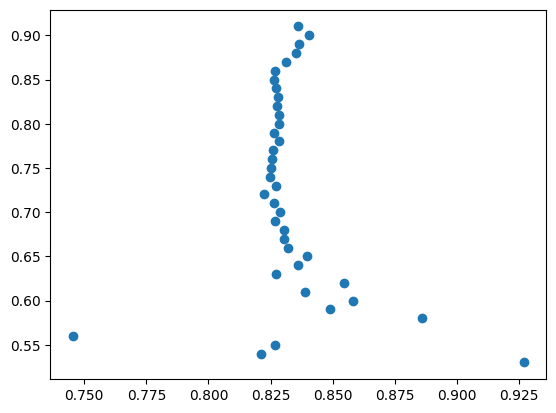

In [ ]:
dot_avg = []
for i in np.unique(total_csr):
    dot_avg.append(total_init_cond_dot[np.where(total_csr==i)].mean())

plt.scatter(dot_avg, np.unique(total_csr))

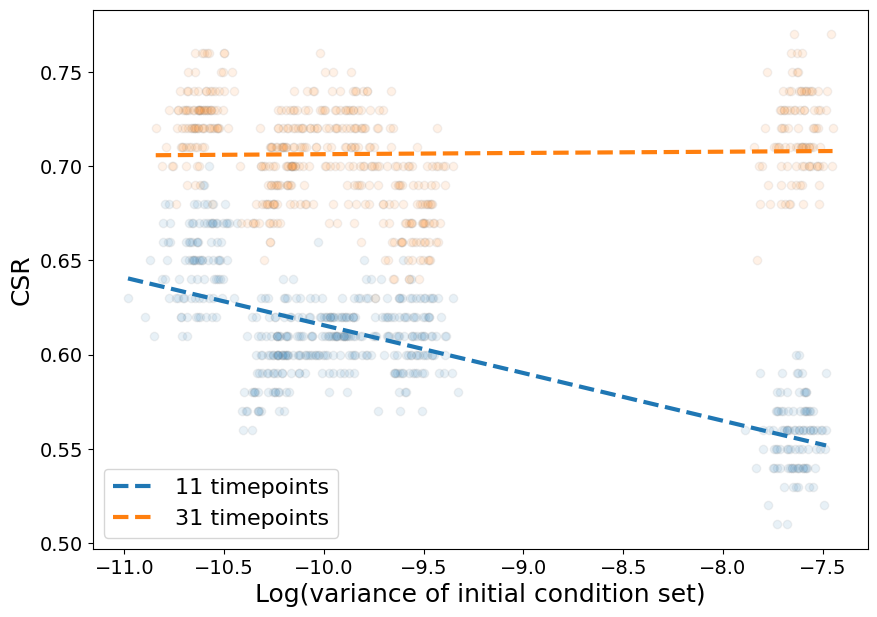

In [ ]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_var = []
    total_csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(10,11):
            df_tmp = df[df["n_dset"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_var = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_var.append(init_cond-x_eq/10)
                csr.append(df_tmp.CSR.values[l])

            init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
            csr = np.array(csr)

            total_init_cond_var.append(init_cond_var)
            total_csr.append(csr)

    total_init_cond_var = np.concatenate(total_init_cond_var)
    total_csr = np.concatenate(total_csr)

    plt.scatter(np.log(total_init_cond_var), total_csr,
                c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(total_init_cond_var).reshape((-1, 1)), total_csr)
    plt.plot([np.log(total_init_cond_var).min(), np.log(total_init_cond_var).max()],
             reg.predict([[np.log(total_init_cond_var).min()],
                         [np.log(total_init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


In [ ]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1, j]/avgCSR[0, i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2, j]/avgCSR[0, i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2, j]/avgCSR[1, i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))


IndexError: index 2 is out of bounds for axis 0 with size 2

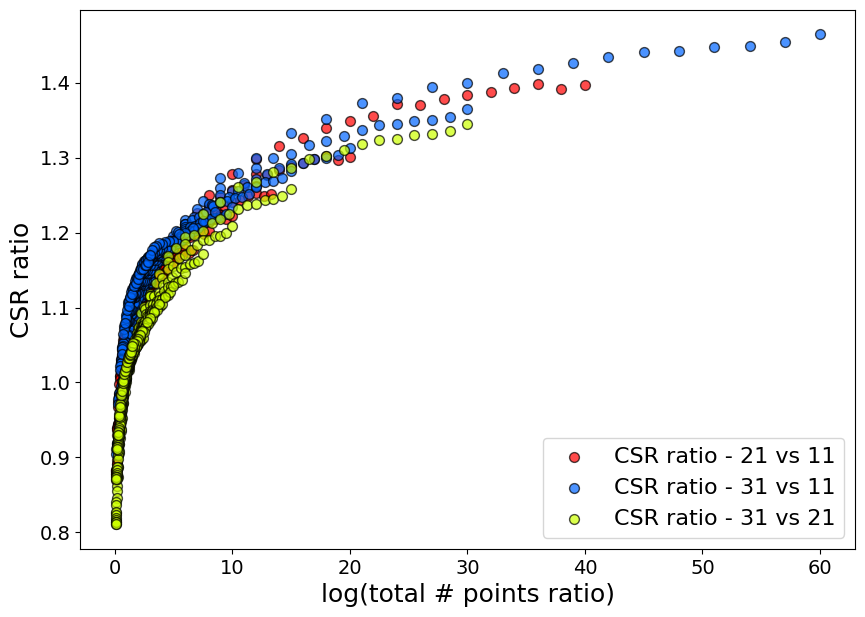

In [ ]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

# 12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9635744529656103
intercept = 1.05249, slope = 0.08432

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9649025800699904
intercept = 1.06118, slope = 0.08726

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9762911292606669
intercept = 1.01116, slope = 0.08608

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9339807335774234
intercept = 1.03862, slope = 0.09019


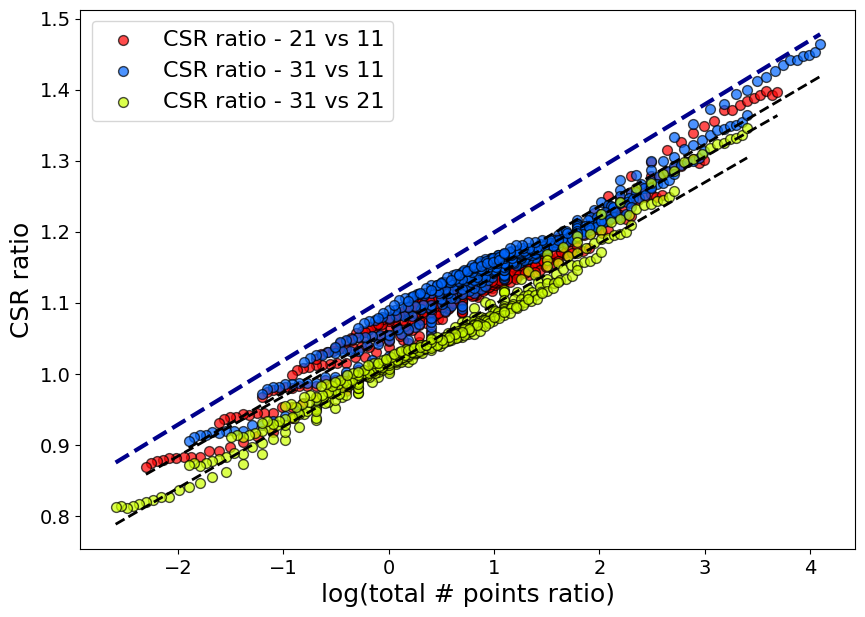

In [ ]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9633803626368352
intercept = 0.04865, slope = 0.07617

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.965094411816569
intercept = 0.05906, slope = 0.07564

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9829660763223779
intercept = 0.00740, slope = 0.08217

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9334623124207811
intercept = 0.03475, slope = 0.08195


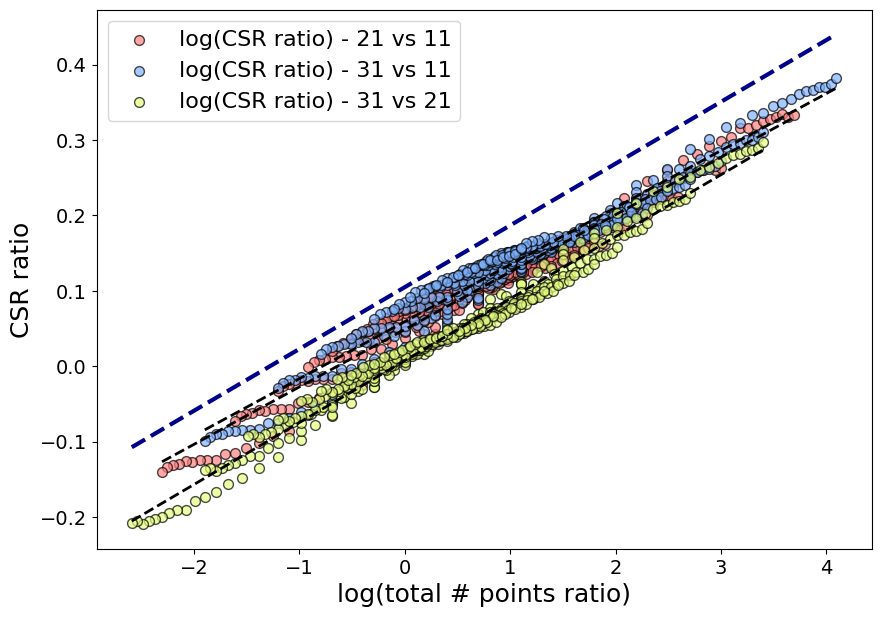

In [ ]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


R2 score = 0.6094385869352812


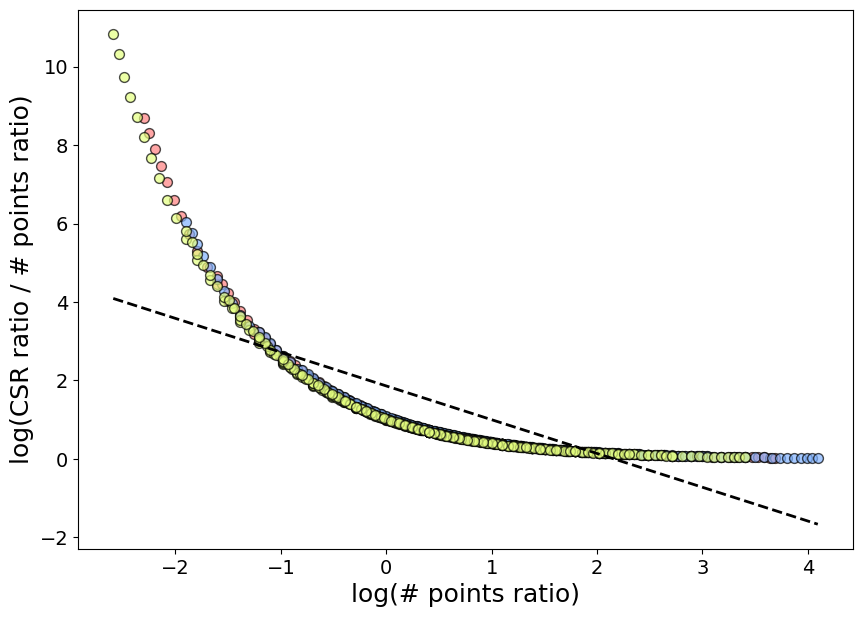

In [ ]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01,
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02,
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12,
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


R2 score = 0.999432384133498


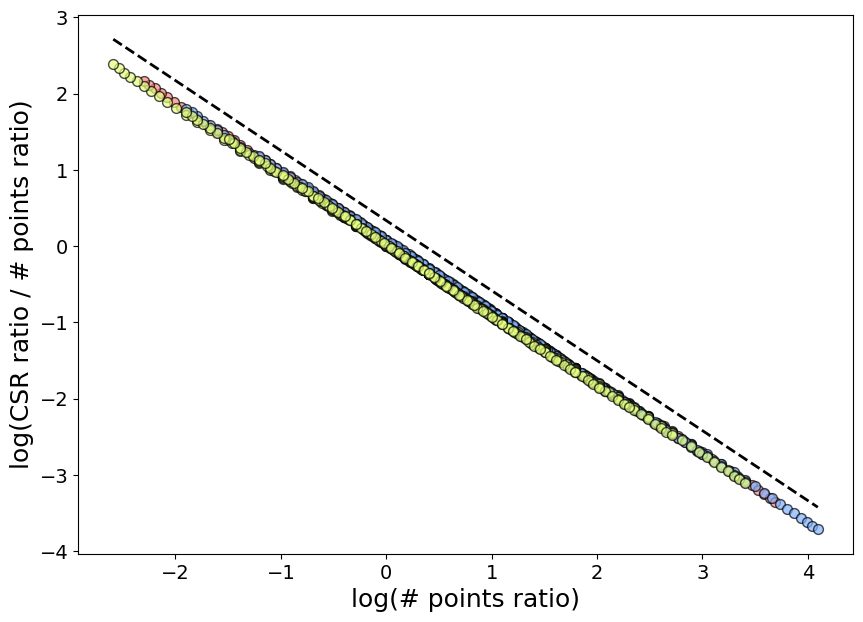

In [ ]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01),
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02),
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12),
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)),
        np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape(
    (-1, 1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


---

In [ ]:
def lr_fim(x, y, lr, Sig):
    S = np.zeros((np.prod(x.shape), x.shape[1]*(x.shape[1]+1)))
    for i in range(x.shape[1]):
        S[i::x.shape[1], i] = 1.
        S[i::x.shape[1], (i+1)*x.shape[1]:(i+2)*x.shape[1]] = x

    F = S.T@np.diag(list(1/Sig)*x.shape[0])@S

    return F


In [ ]:
def taros(x, y, lr):
    rms = np.zeros_like(lr.coef_)
    for i in range(rms.shape[0]):
        rms[i] = np.sqrt(((lr.coef_[i]*x/y[:,[i]])**2).sum(0))/len(x)

    return rms


In [ ]:
def BIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*np.log(len(x)) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AICc(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p*(n_p+1)/(len(y)-n_p-1) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def CAICF(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*(np.log(len(x))+2) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y) - np.log(np.linalg.det(lr_fim(x, y, lr, Sig)))

In [ ]:
a = pd.read_csv(datafiles[2][2], index_col=0)
add_log_time_diff(a)

reg = lm.RidgeCV(alphas=10.**np.arange(-5, 3))
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

Sig = (dlogydt-reg.predict(y)).var(0)

F = lr_fim(y, dlogydt, reg, Sig)
cov = np.linalg.inv(F)

print(BIC(y, dlogydt, reg, Sig), AIC(y, dlogydt, reg, Sig),
      AICc(y, dlogydt, reg, Sig), CAICF(y, dlogydt, reg, Sig), np.log(np.linalg.det(taros(y, dlogydt, reg))))

105440.12196867273 104956.45970659895 104786.3983569057 105325.48706764655 8.158136926731785


In [ ]:
a["dt"].unique()

array([ 1., nan])

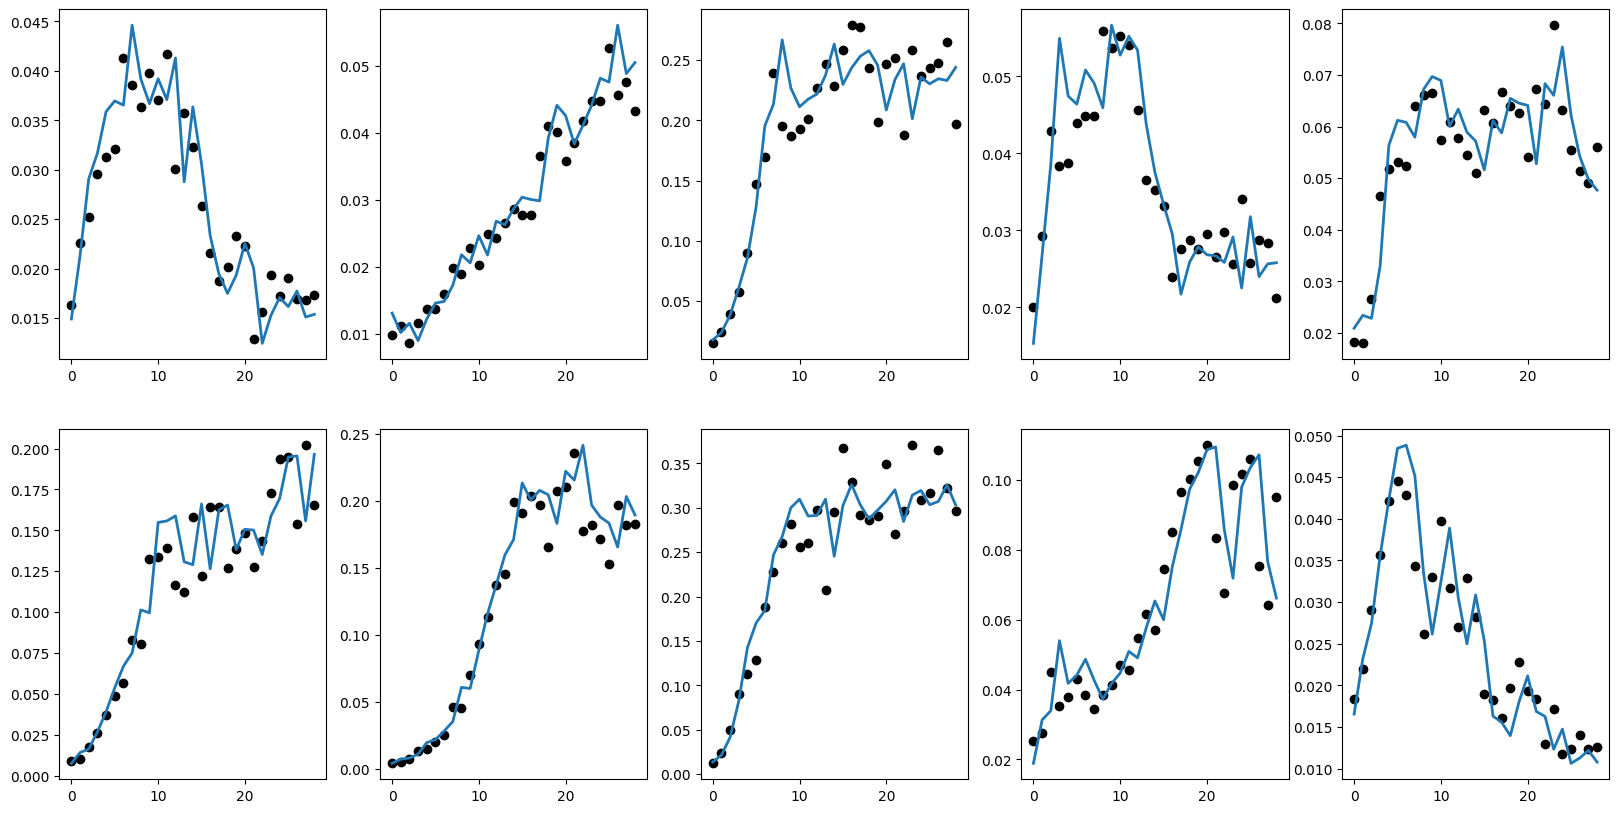

In [ ]:
reg_ = lm.RidgeCV()
reg_.fit(y[:30], dlogydt[:30])
plt.subplots(2, 5, figsize=(20,10))
# reg_.intercept_ = true_r
# reg_.coef_ = true_A
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.plot(y[1:30,i], "o", c="k")
    plt.plot((y[:29]+1.5*y[:29]*reg_.predict(y[:29]))[:,i], lw=2)
    # plt.ylim(0, 0.4)

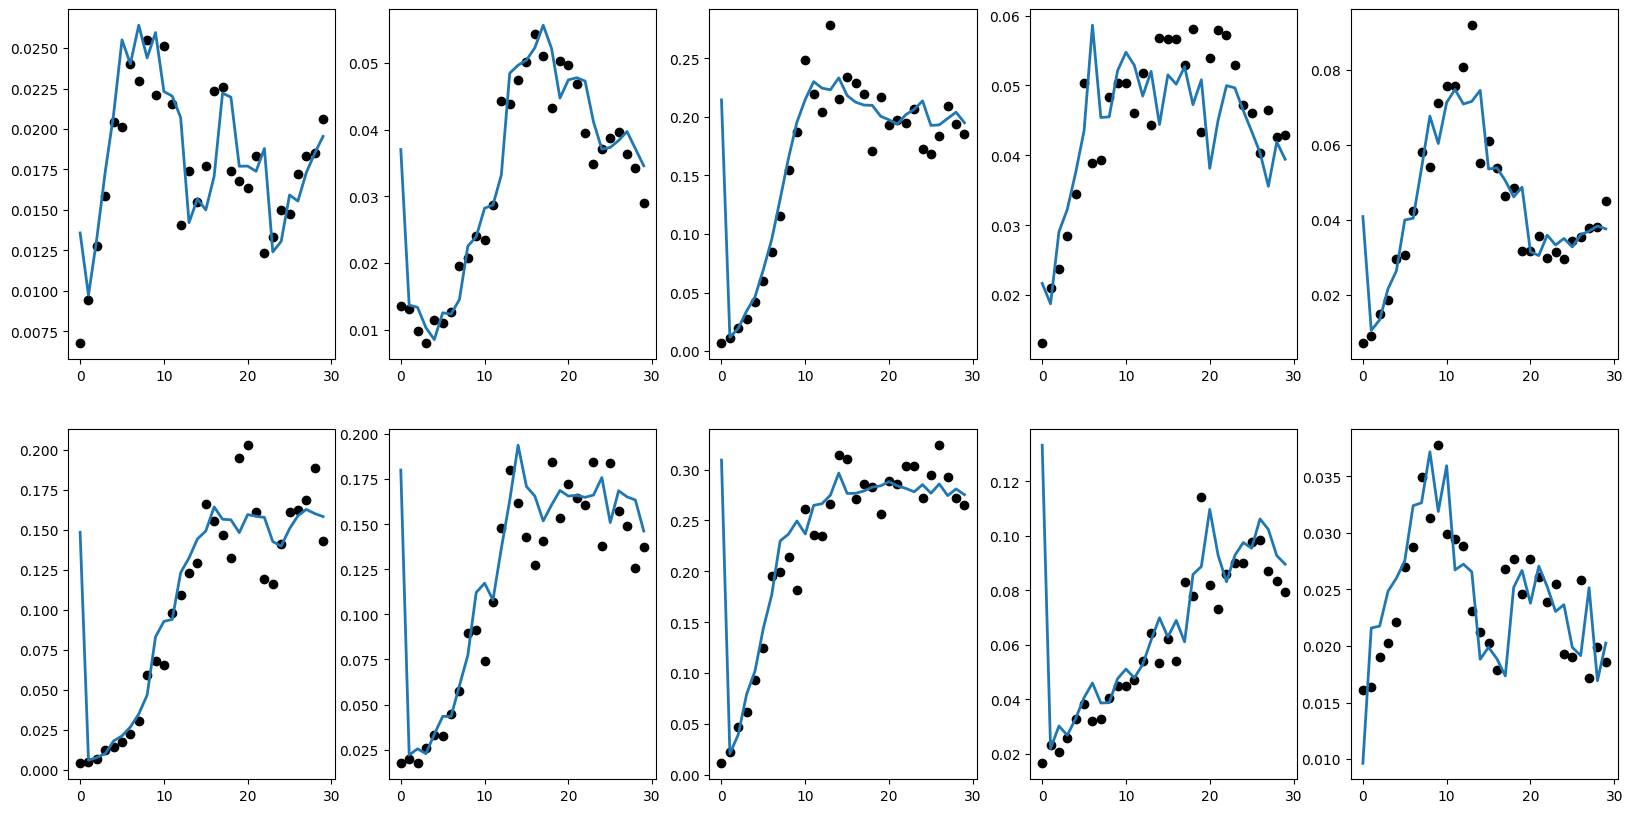

In [ ]:
reg_ = lm.RidgeCV()
# reg_ = lm.RidgeCV(alphas=10.**np.arange(-5, 3))
reg_.fit(y[:-30], dlogydt[:-30])
plt.subplots(2, 5, figsize=(20,10))
# reg_.intercept_ = true_r
# reg_.coef_ = true_A
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.plot(y[-30:,i], "o", c="k")
    plt.plot((y[-31:-1]+1.5*y[-31:-1]*reg_.predict(y[-31:-1]))[:,i], lw=2)
    # plt.ylim(0, 0.4)

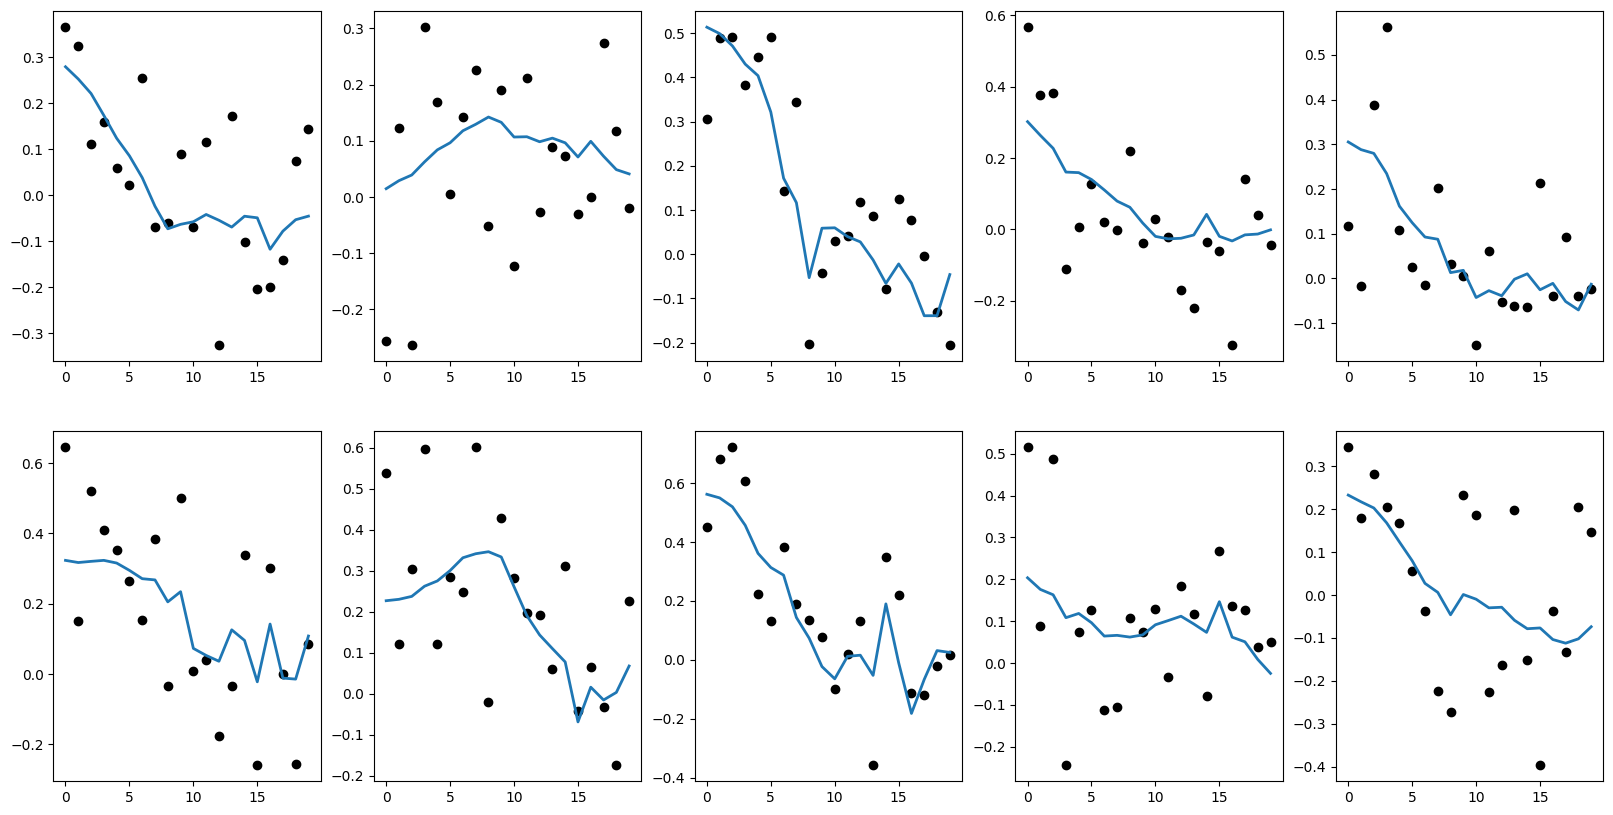

In [ ]:
plt.subplots(2, 5, figsize=(20,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.plot(dlogydt[:20,i], "o", c="k")
    plt.plot(reg_.predict(y[:20])[:,i], lw=2)
    # plt.ylim(0, 0.4)

In [ ]:
(np.sign(true_A)==np.sign(reg_.coef_)).mean()

NameError: name 'true_A' is not defined

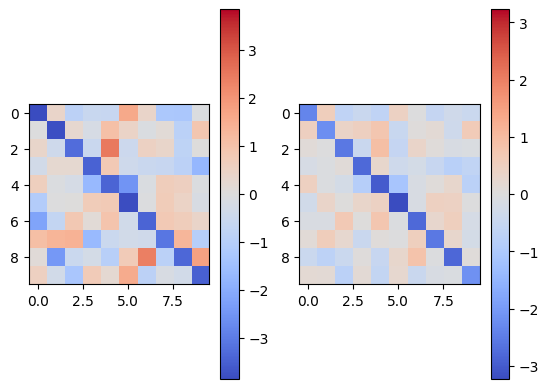

In [ ]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(true_A, cmap="coolwarm", vmin=-np.abs(true_A).max(), vmax=np.abs(true_A).max())
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(reg_.coef_, cmap="coolwarm", vmin=-np.abs(reg_.coef_).max(), vmax=np.abs(reg_.coef_).max())
plt.colorbar()
plt.show()

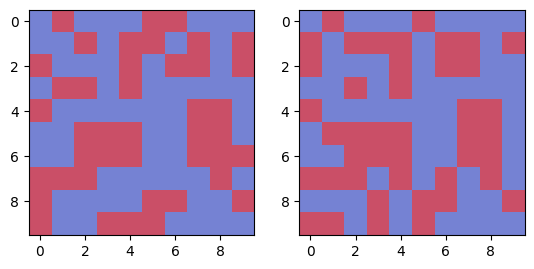

In [ ]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(np.sign(true_A), cmap="coolwarm", alpha=0.7)
plt.subplot(1, 2, 2)
plt.imshow(np.sign(reg_.coef_), cmap="coolwarm", alpha=0.7)

In [ ]:
reg__coef_no_diag = np.concatenate([reg_.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
cov_no_diag = np.diag(cov)[n_sp:][[i for i in range(n_sp**2) if i%11!=0]]

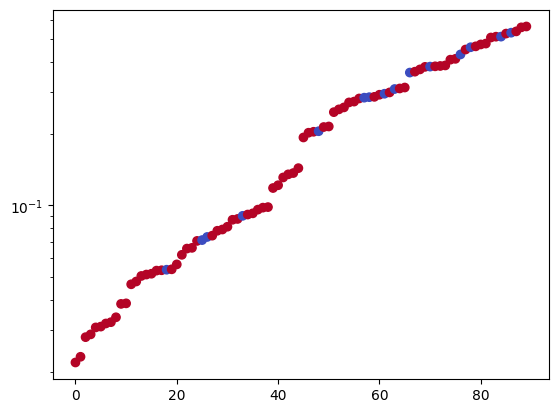

In [ ]:
plt.scatter(np.arange(90), (cov_no_diag)[np.argsort(cov_no_diag)], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(cov_no_diag)], cmap="coolwarm")
plt.yscale("log")

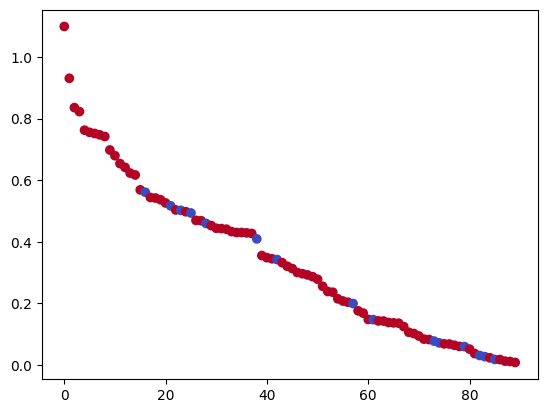

In [ ]:
plt.scatter(np.arange(90), np.abs(reg__coef_no_diag)[np.argsort(np.abs(reg__coef_no_diag))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.abs(reg__coef_no_diag))][::-1], cmap="coolwarm")

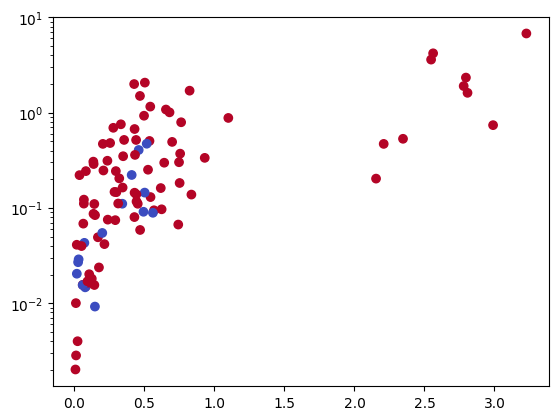

In [ ]:
plt.scatter(np.abs(reg_.coef_), taros(y, dlogydt, reg_), c=(np.sign(true_A)==np.sign(reg_.coef_)).flatten(), cmap="coolwarm")
plt.yscale("log")

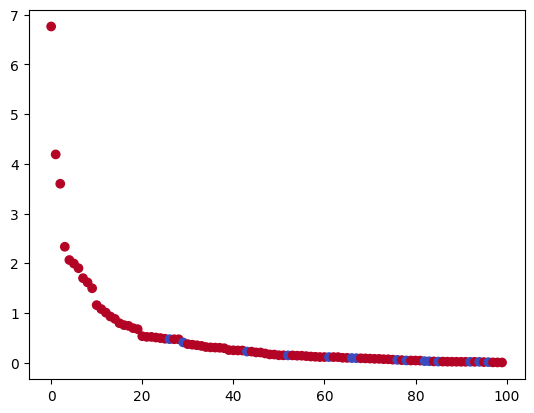

In [ ]:
plt.scatter(np.arange(100), taros(y, dlogydt, reg_).flatten()[np.argsort(taros(y, dlogydt, reg_).flatten())][::-1], c=(np.sign(true_A)==np.sign(reg_.coef_)).flatten()[np.argsort(taros(y, dlogydt, reg_).flatten())][::-1], cmap="coolwarm")
# plt.yscale("log")

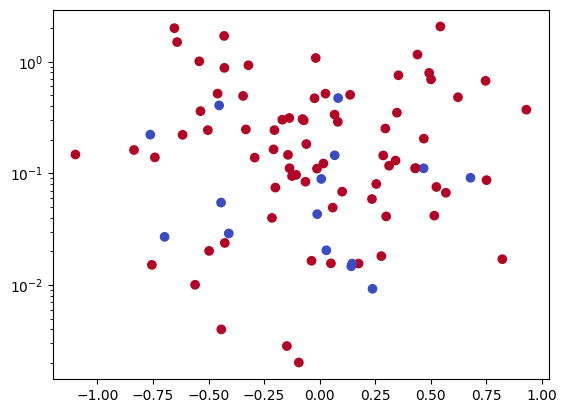

In [ ]:
plt.scatter(reg__coef_no_diag, np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

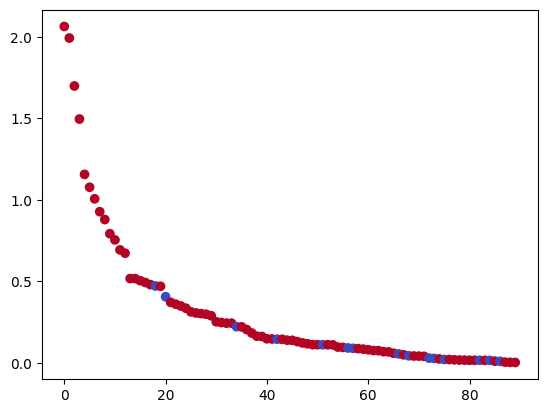

In [ ]:
plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
# plt.yscale("log")

In [ ]:
n_sp = 10

In [ ]:
true_params = get_meta(open(metadatafiles[0][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg.coef_)).mean(), np.sqrt(((true_A-reg.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg.coef_).flatten()**2/np.diag(cov)[n_sp:]).mean()), reg.score(y[:], dlogydt[:]), np.linalg.det(F))

0.78 0.8190495125581138 3.628636905345443 0.7323727007045561 9.913221253573126e+178


In [ ]:
rmsd = []
csr = []
# for dset in a.dataset.unique():
for k in range(10, 15):
    combs = list(combinations(a["dataset"].unique(), k))
    np.random.shuffle(combs)
    combs = combs[:100]
    for comb in combs:
        a_train = pd.concat([a[a["dataset"]==i] for i in comb])
        a_test = pd.concat([a[a["dataset"]==i] for i in a["dataset"].unique() if i not in comb])
        y_train = a_train.dropna()[[i for i in a_train.columns if i[:2] == "sp"]].values
        y_test = a_test.dropna()[[i for i in a_test.columns if i[:2] == "sp"]].values
        dlogydt_train = a_train.dropna()[[i for i in a_train.columns if i[:6] == "dlogsp"]].values
        dlogydt_test = a_test.dropna()[[i for i in a_test.columns if i[:6] == "dlogsp"]].values
        
        reg = lm.LinearRegression()
        reg.fit(y_train, dlogydt_train)
        
        csr.append((np.sign(true_A)==np.sign(reg.coef_)).mean())
        rmsd.append(((dlogydt_test-reg.predict(y_test))**2).sum()**0.5)

csr = np.array(csr)
rmsd = np.array(rmsd)

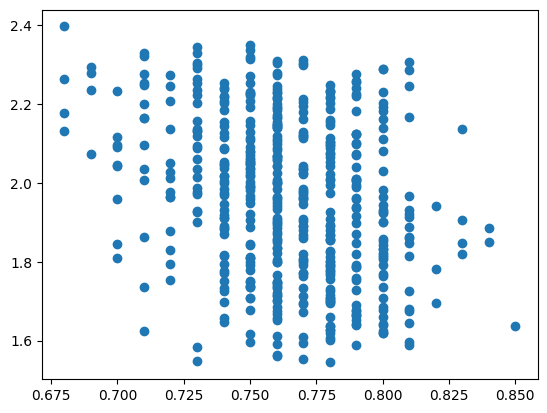

In [ ]:
plt.scatter(csr, rmsd)
reg_ = lm.LinearRegression()
# plt.yscale("log")
# plt.xscale("log")

In [ ]:
rmsd_mean = []
for i in np.unique(csr):
    rmsd_mean.append(rmsd[np.where(csr==i)].mean())

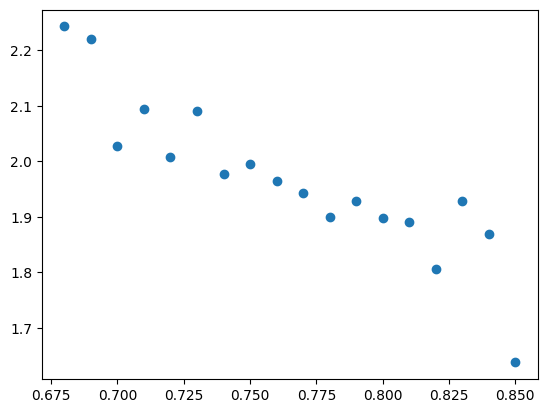

In [ ]:
plt.plot(np.unique(csr), rmsd_mean, "o")

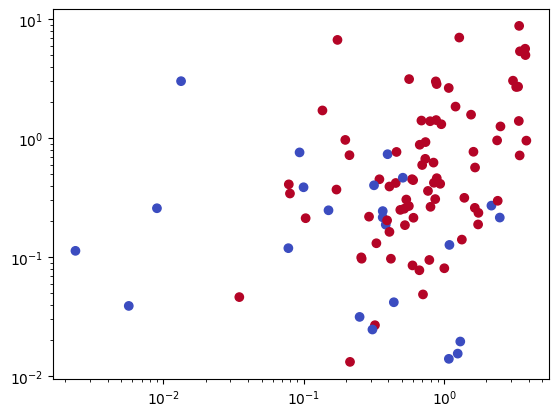

In [ ]:
plt.scatter(np.abs(true_A).flatten(), taros(y, dlogydt, reg).flatten(), c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
# plt.colorbar()
plt.xscale("log")
plt.yscale("log")

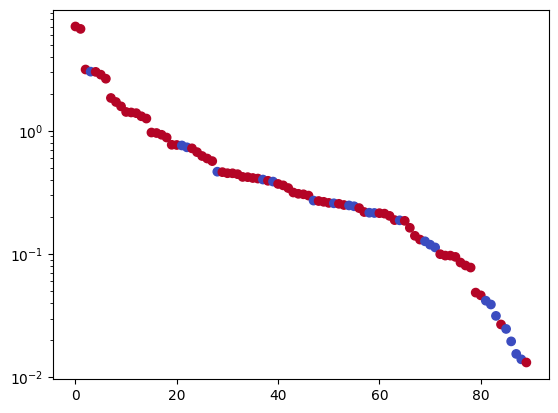

In [ ]:
reg_coef_no_diag = np.concatenate([reg.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])

plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg_coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

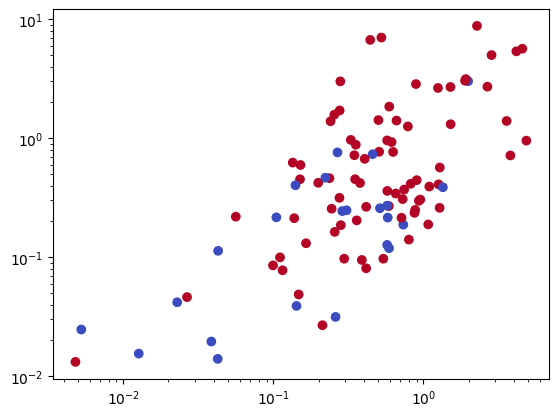

In [ ]:
plt.scatter(np.abs(reg.coef_).flatten(), taros(y, dlogydt, reg).flatten(), c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
# plt.colorbar()
plt.xscale("log")
plt.yscale("log")

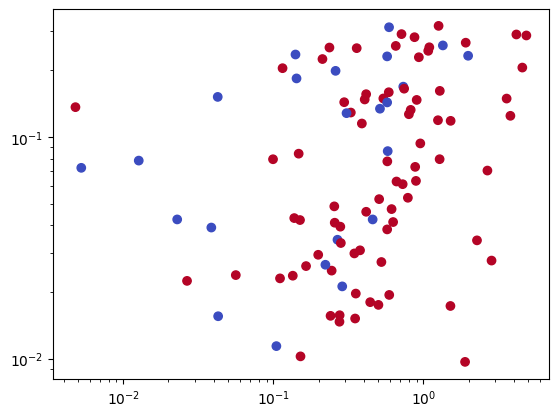

In [ ]:
plt.scatter(np.abs(reg.coef_).flatten(), np.diag(cov)[n_sp:], c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

In [ ]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a["dataset"].unique():
y = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

4.866505164708734 0.0
0.004747361438213974 0.0
0.6783660304721053 0.0
14798.911655140659 0.0
14523.93259140433 0.0
13141.075448547188 0.0
8.124778961670547e+132 0.0


In [ ]:
a2 = pd.read_csv(datafiles[2][3], index_col=0)
add_log_time_diff(a2)

reg2 = lm.RidgeCV(alphas=10.**np.arange(-5,3))
y2 = a2.dropna()[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt2 = a2.dropna()[[i for i in a2.columns if i[:6] == "dlogsp"]].values
reg2.fit(y2, dlogydt2)

Sig2 = (dlogydt2-reg2.predict(y2)).var(0)

F2 = lr_fim(y2, dlogydt2, reg2, Sig2)
cov2 = np.linalg.inv(F2)

print(BIC(y2, dlogydt2, reg2, Sig2), AIC(y2, dlogydt2, reg2, Sig2),
      AICc(y2, dlogydt2, reg2, Sig2), CAICF(y2, dlogydt2, reg2, Sig2), np.log(np.linalg.det(taros(y2, dlogydt2, reg2))))

104361.26375126571 103877.60148919193 103707.54013949868 104004.85126371519 16.299858413964827


In [ ]:
n_sp = 10

In [ ]:
true_params = get_meta(open(metadatafiles[2][3]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg2.coef_)).mean(), np.sqrt(((true_A-reg2.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg2.coef_).flatten()**2/np.diag(cov2)[n_sp:]).mean()), reg2.score(y2[:], dlogydt2[:]), np.linalg.det(F2))

0.76 1.0557548962955348 16.41795115720639 0.5990207874768088 2.151605487860768e+250


In [ ]:
reg2_coef_no_diag = np.concatenate([reg2.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])

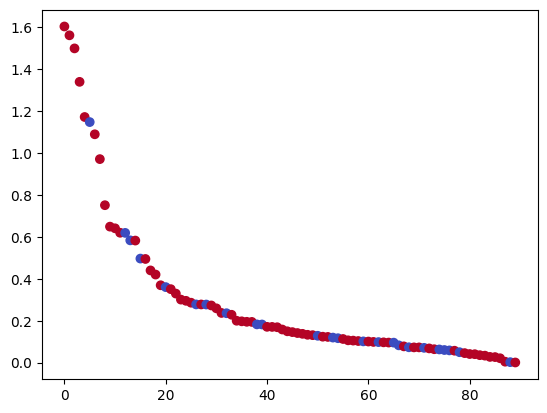

In [ ]:
plt.scatter(np.arange(90), np.abs(reg2_coef_no_diag)[np.argsort(np.abs(reg2_coef_no_diag))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag))[np.argsort(np.abs(reg2_coef_no_diag))][::-1], cmap="coolwarm")

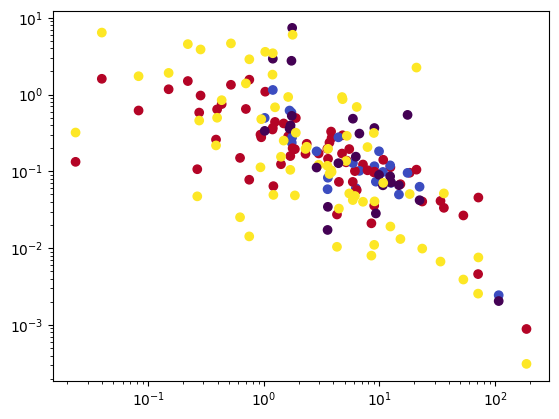

In [ ]:
plt.scatter(np.abs((reg2_coef_no_diag-true_A_no_diag)/reg2_coef_no_diag), np.abs(reg2_coef_no_diag), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.scatter(np.abs(reg2_coef_no_diag-true_A_no_diag)/np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)))
plt.xscale("log")
plt.yscale("log")

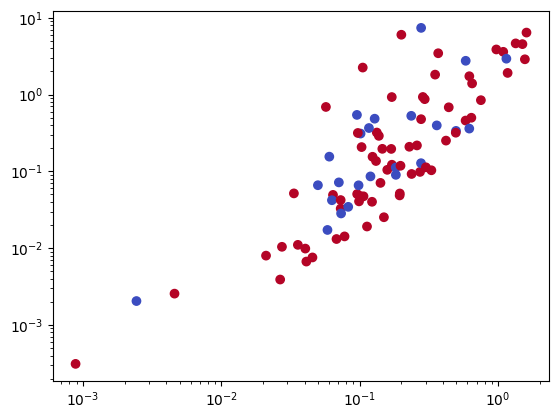

In [ ]:
plt.scatter(np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

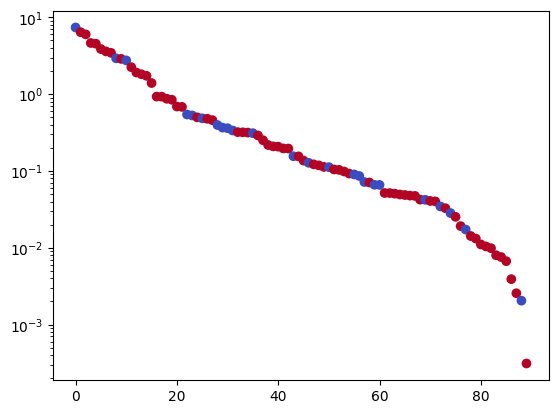

In [ ]:
plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

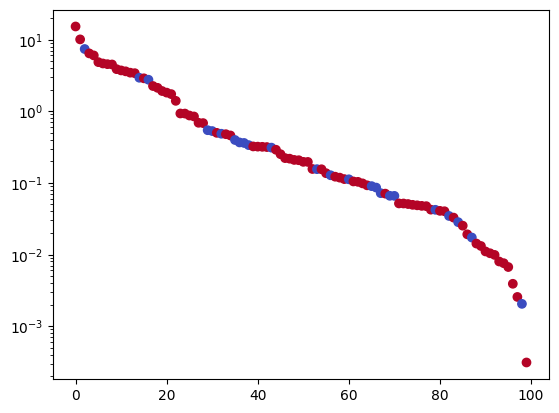

In [ ]:
plt.scatter(np.arange(100), taros(y, dlogydt, reg2).flatten()[np.argsort(taros(y, dlogydt, reg2).flatten())][::-1], c=(np.sign(true_A)==np.sign(reg2.coef_)).flatten()[np.argsort(taros(y, dlogydt, reg2).flatten())][::-1], cmap="coolwarm")
plt.yscale("log")

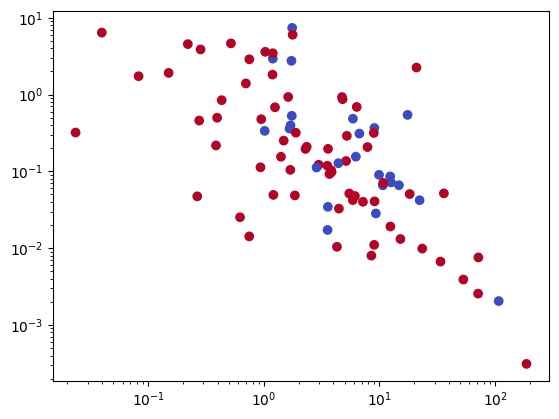

In [ ]:
plt.scatter(np.abs(reg2_coef_no_diag-true_A_no_diag)/np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

NameError: name 'st' is not defined

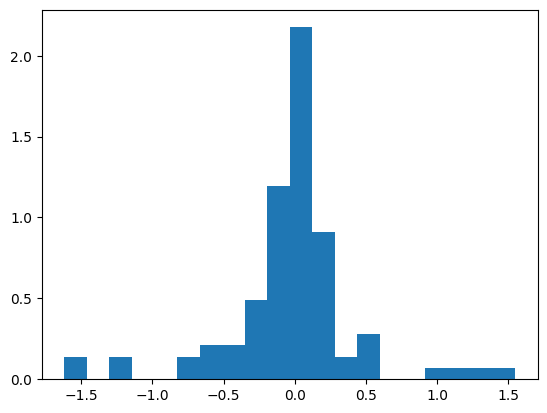

In [ ]:
plt.hist((reg2_coef_no_diag-reg2_coef_no_diag.mean()/reg2_coef_no_diag.std()), 20, density=True)
plt.plot(np.linspace(-3, 3, 1000), st.norm.pdf(np.linspace(-3, 3, 1000), ))
plt.plot(np.linspace(-3, 3, 1000), st.laplace.pdf(np.linspace(-3, 3, 1000), scale=1/2**0.5))

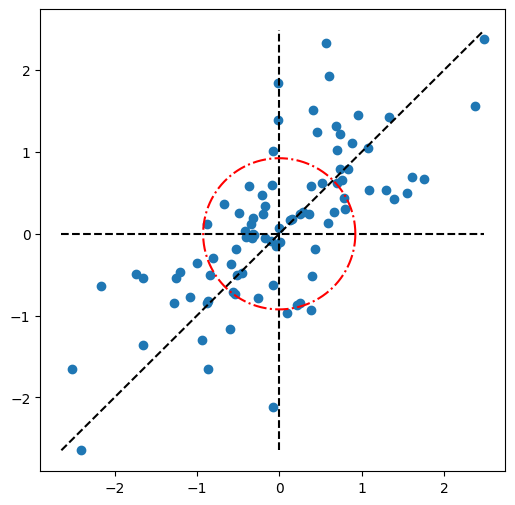

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(true_A_no_diag, reg2_coef_no_diag)
plt.plot(np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], c="k", ls="--")
plt.plot([0, 0], np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], c="k", ls="--")
plt.plot(np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], [0, 0], c="k", ls="--")
theta = np.linspace(0, 2*np.pi, 1000)
plt.plot(reg2_coef_no_diag.std()*np.cos(theta), reg2_coef_no_diag.std()*np.sin(theta), c="r", ls="-.")

In [ ]:
import scipy.stats as st

In [ ]:
st.spearmanr(np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))

SpearmanrResult(correlation=0.5392352965386672, pvalue=4.1697950995028686e-08)

In [ ]:
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

16853023.32213465
138366.6479840501


In [ ]:
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

3074496.0474326178
188519.79783352828


In [ ]:
print(AICc(y, dlogydt, reg, Sig))
print(AICc(y, dlogydt, reg2, Sig2))

33222.735228258796
85101.13569627122


In [ ]:
print(AICc(y2, dlogydt2, reg, Sig))
print(AICc(y2, dlogydt2, reg2, Sig2))

3041562.1902066004
103707.54013949868


In [ ]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a2["dataset"].unique():
y = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

4.800759782466054 0.0
0.021024552550012485 0.0
0.5812864584771325 0.0
47420.86748167546 0.0
47025.04106618564 0.0
46958.62597184601 0.0
3.2586607358819524e+213 0.0


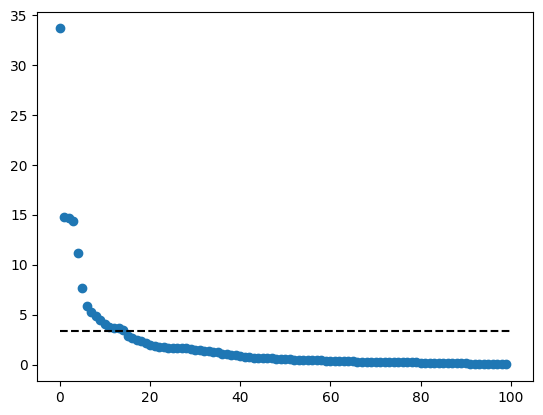

In [ ]:
plt.plot(np.sort((taros(y, dlogydt, reg).flatten()))[::-1], "o")
plt.hlines(np.sort((taros(y, dlogydt, reg).flatten()))
           [::-1].max()/10, 0, 100, color="k", ls="--")


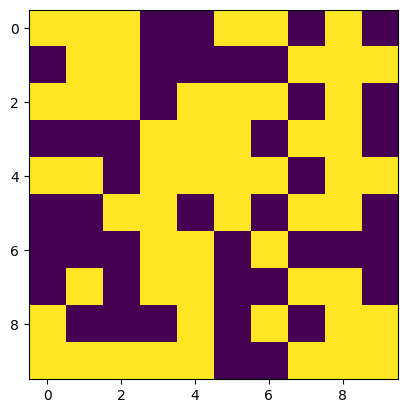

In [ ]:
plt.imshow((np.sign(true_A) == np.sign(reg.coef_)))


0.4272456332420541 0.5839126594294045


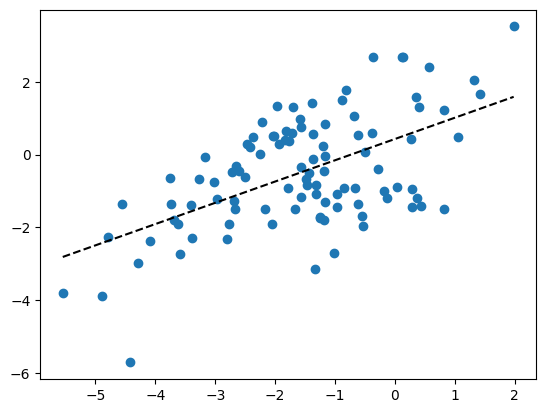

In [ ]:
plt.scatter(np.log(np.abs(reg.coef_).flatten()),
            np.log(taros(y, dlogydt, reg).flatten()))
meta_reg = lm.LinearRegression()
meta_reg.fit(np.log(np.abs(reg.coef_).flatten()).reshape(
    (-1, 1)), np.log(taros(y, dlogydt, reg).flatten()))
plt.plot(np.sort(np.log(np.abs(reg.coef_).flatten()))[[0, -1]], meta_reg.predict(np.sort(
    np.log(np.abs(reg.coef_).flatten()))[[0, -1]].reshape((-1, 1))), color="k", ls="--")

print(meta_reg.intercept_, meta_reg.coef_[0])


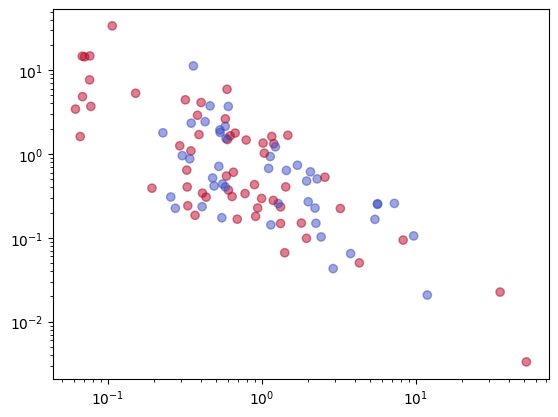

In [ ]:
plt.scatter(np.diag(cov)[n_sp:]**0.5/np.abs(reg.coef_).flatten(), taros(y, dlogydt, reg).flatten(),
            c=(np.sign(reg.coef_) == np.sign(true_A)).flatten(), cmap="coolwarm", alpha=0.5)
plt.xscale("log")
plt.yscale("log")


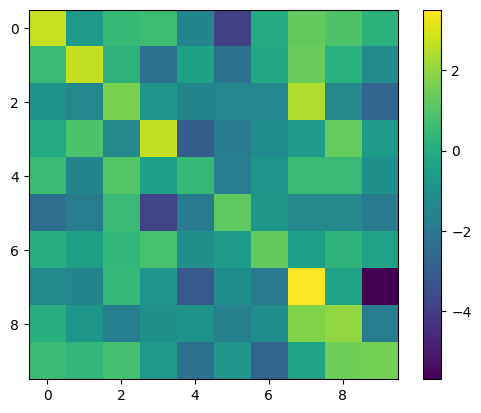

In [ ]:
plt.imshow(np.log(taros(y, dlogydt, reg).T))
plt.colorbar()
plt.show()


In [ ]:
from scipy.linalg import block_diag
import scipy.stats as st

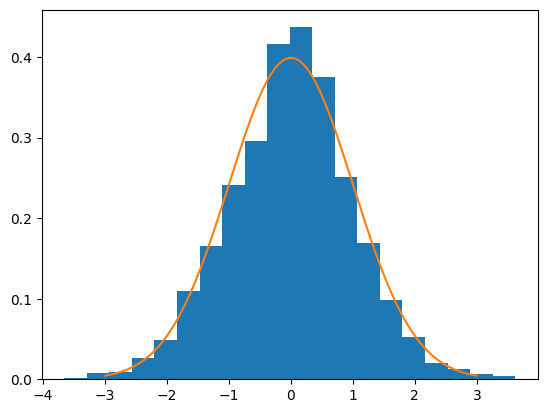

In [ ]:
plt.hist(((dlogydt-reg.predict(y))/(dlogydt-reg.predict(y)).std()
          ).flatten(), 20, density=True)
l = np.linspace(-3, 3, 1000)
plt.plot(l, st.norm.pdf(l))


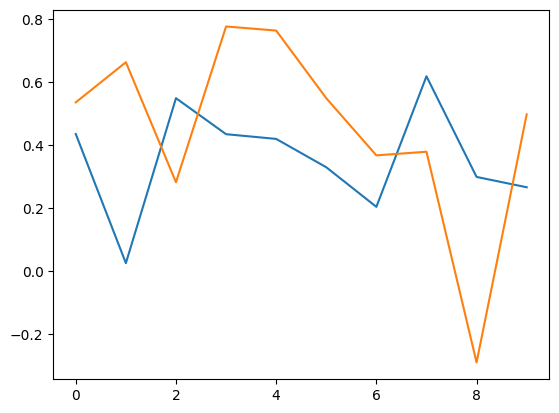

In [ ]:
plt.plot(true_params[:n_sp])
plt.plot(reg.intercept_)


In [ ]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.57

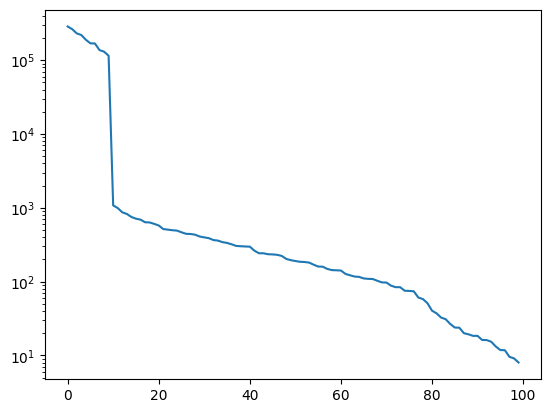

In [ ]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


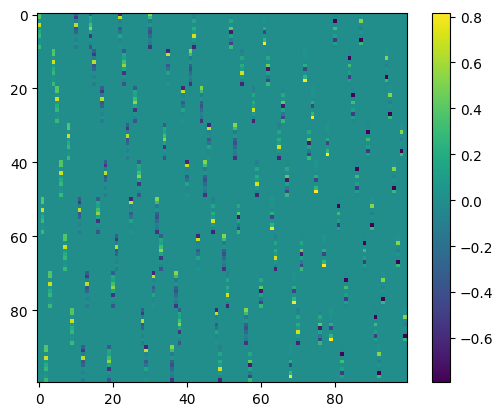

In [ ]:
plt.imshow(np.linalg.eig(F[n_sp:, n_sp:])[1][:, np.argsort(
    np.linalg.eig(F[n_sp:, n_sp:])[0])][:, ::-1])
plt.colorbar()


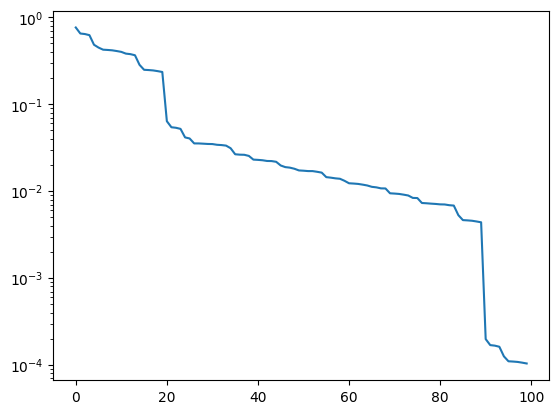

In [ ]:
plt.plot(np.sort(np.linalg.eig(cov[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


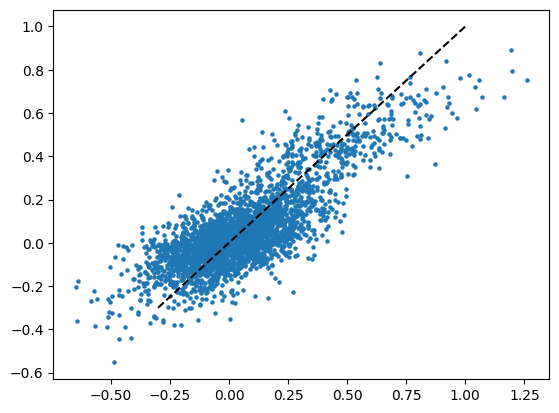

In [ ]:
plt.scatter(dlogydt, reg.predict(y), s=5)
plt.plot([-0.3, 1], [-0.3, 1], ls="--", c="k")


In [ ]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.57

(array([0.03696031, 0.07392061, 0.07392061, 0.40656338, 0.22176184,
        0.29568245, 0.14784123, 0.22176184, 0.07392061, 0.03696031]),
 array([-3.87371482, -3.2445043 , -2.61529378, -1.98608325, -1.35687273,
        -0.72766221, -0.09845169,  0.53075883,  1.15996935,  1.78917987,
         2.4183904 ]),
 [<matplotlib.patches.Polygon at 0x7fbcfc04f8b0>])

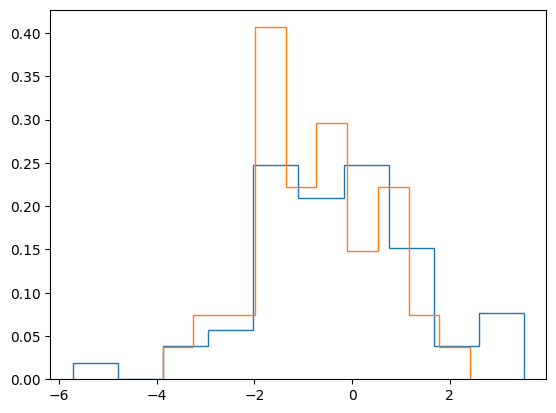

In [ ]:
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) == np.sign(reg.coef_)).flatten()], histtype="step", density=True)
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) != np.sign(reg.coef_)).flatten()], histtype="step", density=True)
# plt.yscale("log")


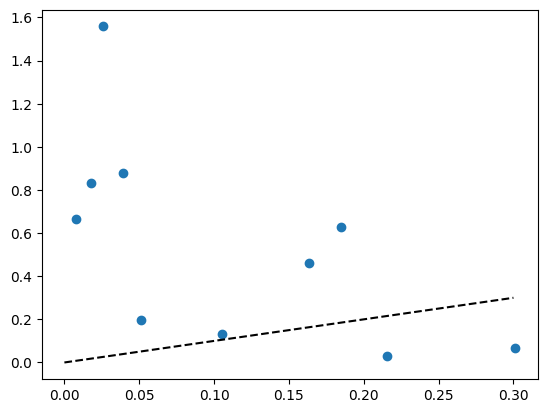

In [ ]:
plt.scatter(-np.linalg.inv(true_A)@true_r, -
            np.linalg.inv(reg.coef_)@reg.intercept_)
plt.plot([0, 0.3], [0, 0.3], c="k", ls="--")


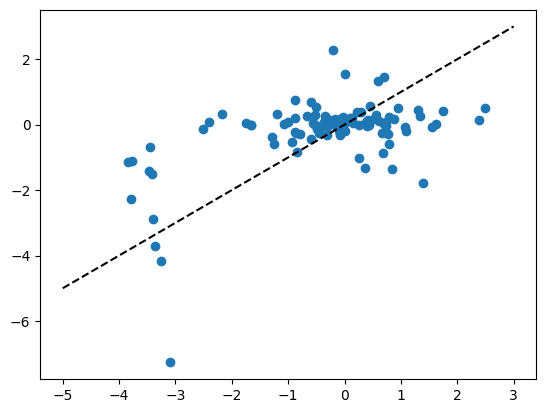

In [ ]:
plt.scatter(true_A.flatten(), reg.coef_.flatten())
plt.plot([-5, 3], [-5, 3], c="k", ls="--")


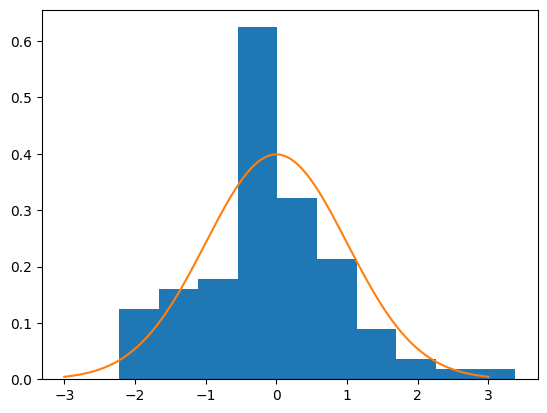

In [ ]:
import scipy.stats as st
plt.hist((true_A-reg.coef_).flatten() /
         (true_A-reg.coef_).std(), 10, density=True)
x = np.linspace(-3, 3, 1000)
plt.plot(x, st.norm.pdf(x, scale=1))


In [ ]:
(np.abs(true_A-reg.coef_).flatten()/np.diag(cov)[n_sp:]**0.5 < 0.5).mean()


0.07

<ErrorbarContainer object of 3 artists>

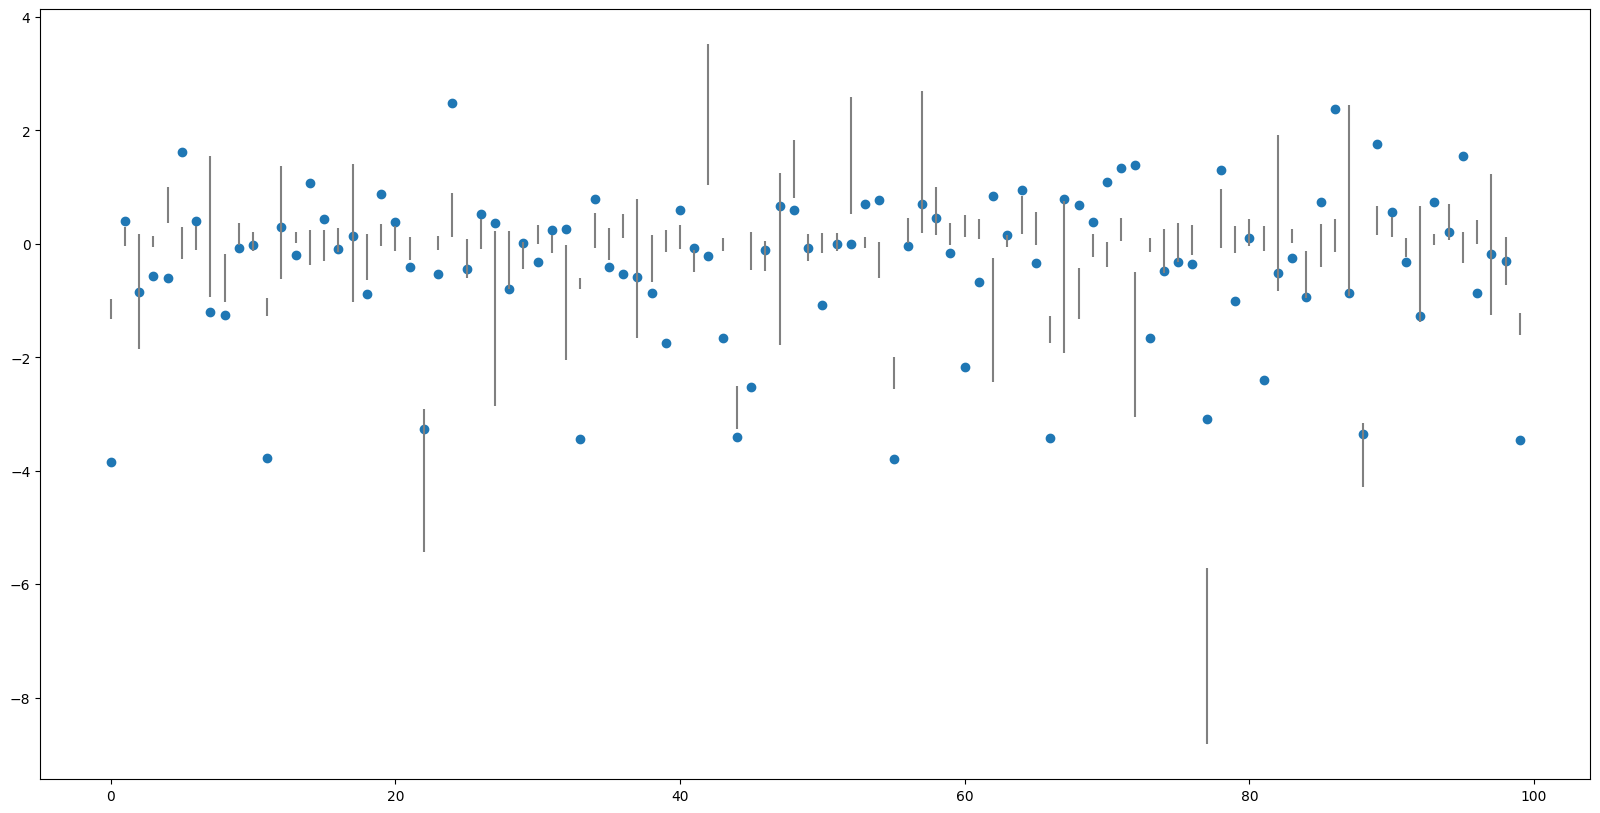

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(true_A.flatten(), "o")
# plt.plot(reg.coef_.flatten())
plt.errorbar(np.arange(n_sp**2), reg.coef_.flatten(), 2 *
             np.diag(cov)[n_sp:]**0.5, c="gray", fmt="none")
# plt.fill_between(np.arange(100), reg.coef_.flatten()-2*np.diag(cov)[n_sp:]**0.5, reg.coef_.flatten()+2*np.diag(cov)[n_sp:]**0.5, alpha=0.5, color="gray")


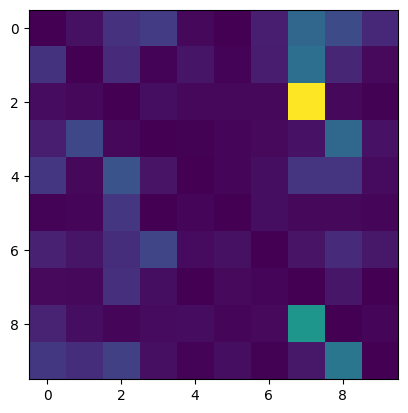

In [ ]:
plt.imshow((taros(y, dlogydt, reg)-np.eye(n_sp)*taros(y, dlogydt, reg)).T)


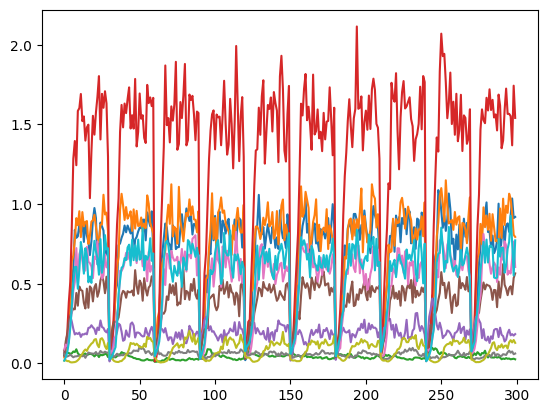

In [ ]:
plt.plot(y)

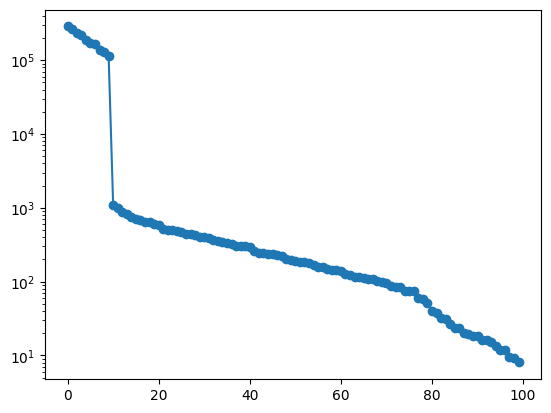

In [ ]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1], "-o")
plt.yscale("log")

In [ ]:
corr = cov.copy()

for i in range(len(cov)):
    for j in range(len(cov)):
        corr[i, j] /= np.sqrt(cov[i, i]*cov[j, j])

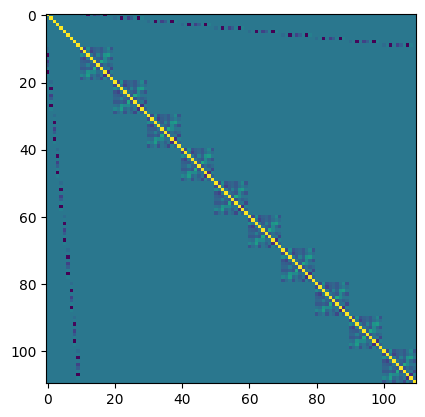

In [ ]:
plt.imshow(corr)

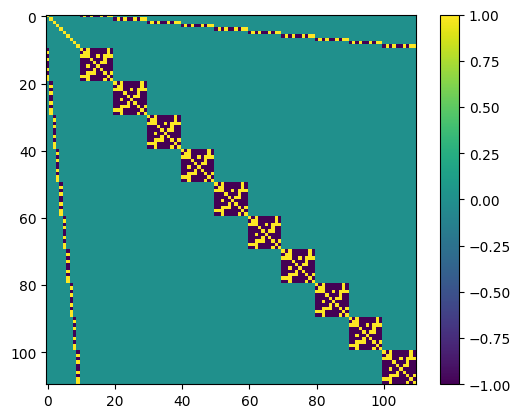

In [ ]:
cov = np.linalg.inv(lr_fim(y, dlogydt, reg, Sig))
plt.imshow(np.sign(cov))
plt.colorbar()
plt.show()

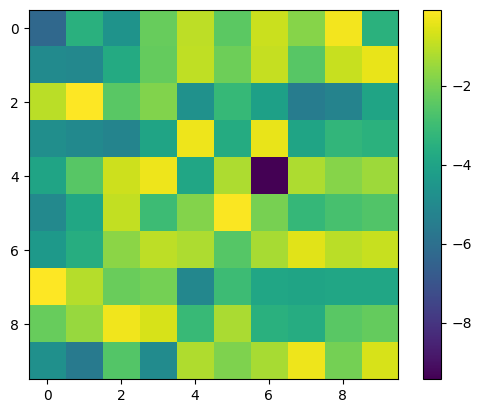

In [ ]:
plt.imshow(np.log(np.abs(np.linalg.eig(cov[n_sp:2*n_sp, n_sp:2*n_sp])[1])))
plt.colorbar()
plt.show()

---

In [ ]:
a = pd.read_csv(datafiles[0][2], index_col=0)

true_params = get_meta(open(metadatafiles[0][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

add_log_time_diff(a)

reg = lm.LinearRegression()
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

LinearRegression()

In [ ]:
dydt = a.dropna()[[i for i in a.columns if i[:3] == "dsp"]].values
dy = dydt*a.dropna()["dt"].values.reshape((-1,1))

In [ ]:
@njit
def glv_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    return x * (r + A.dot(x))

@njit
def glv_and_grad_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    glv_rhs = x * (r + A.dot(x))

    glv_grad_rhs_x = x.reshape((-1,1))*A + np.diag(r + A@x)

    glv_grad_rhs_p = np.zeros((n, n*(n+1)))
    glv_grad_rhs_p[:n,:n] = np.diag(x)
    
    for i in range(n):
        glv_grad_rhs_p[i,n*(i+1):n*(i+2)] = x[i]*x

    return glv_rhs, glv_grad_rhs_x, glv_grad_rhs_p

In [ ]:
-A.sum(0)

array([ 1.15410434, -4.81805271,  5.17769745,  0.36087142,  4.37517978,
       -3.74542755, -0.63132786,  4.39447076, 10.39525556,  9.08344095])

In [ ]:
-np.linalg.inv(A)@(-A.sum(1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
@njit
def euler(f, t, x_, p, n, dt):
    x = np.copy(x_)
    
    for i in range(n):
        x += dt * f(x, p)

    return x

@njit
def euler_f_and_grad(f_and_grad, t, x_, p, n, dt):
    x = np.copy(x_)
    x_grad_p = np.zeros((len(x), len(x)*(len(x)+1)))
    
    for i in range(n):
        f, f_grad_x, f_grad_p = f_and_grad(x, p)
        x += dt * f
        x_grad_p += dt * (f_grad_x@x_grad_p + f_grad_p)
        # x_grad_p += dt * f_grad_p

    return x, x_grad_p

In [ ]:
@njit
def pred(y, t, p, n):
    out = np.zeros_like(y)
    dt = np.diff(t)
    
    for i in range(len(out)):
        out[i] = euler(glv_rhs, t[i], y[i], p, n, dt[i]/n)

    return out

In [ ]:
@njit
def mse_grad(x, y, t, dt, p, n):
    s = np.zeros(x.shape[1]*(x.shape[1]+1))
    
    for i in range(x.shape[0]):
        pred, pred_grad = euler_f_and_grad(glv_and_grad_rhs, t[i], x[i], p, n, dt[i]/n)

        s += (y[i]-pred)@pred_grad

    return -2*s/(x.shape[0]*x.shape[1])

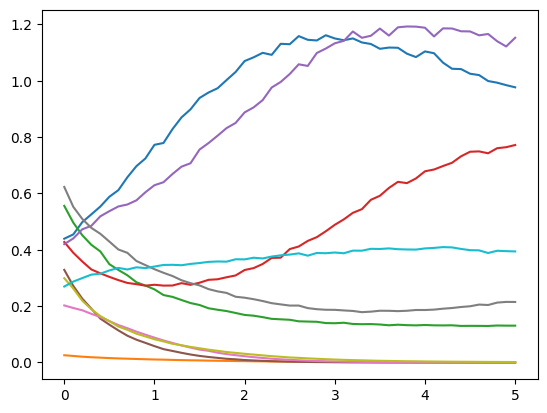

In [ ]:
n_sp = 10

np.random.seed(2)
x = np.random.uniform(0, 1, n_sp)
A = np.random.normal(0, 1, (n_sp,n_sp))
A -= np.eye(n_sp)*A + np.diag(np.abs(np.random.normal(0, 1, n_sp))*3)
r = np.random.uniform(0, 1, n_sp)
# r = -A.sum(1)

p = np.concatenate((r, A.flatten()))

t = 0.
t_hist = [t]
x_hist = [x]
dt = 0.01
n_steps = 50
n_dt = 10

for i in range(n_steps):
    x = euler(glv_rhs, t, x, p, n_dt, dt)
    t += n_dt*dt
    x_hist.append(x)
    t_hist.append(t)

x_hist = np.array(x_hist)
x_hist += np.random.normal(0, 0.01, x_hist.shape)*x_hist
t_hist = np.array(t_hist)

plt.plot(t_hist, x_hist)
plt.show()

In [ ]:
reg = lm.LinearRegression()
reg.fit(x_hist[:-1], np.diff(np.log(x_hist)/(n_dt*dt), axis=0))
p_ = np.concatenate((reg.intercept_, reg.coef_.flatten()))
print((np.sign(reg.coef_)==np.sign(A)).mean())

0.56


In [ ]:
@njit
def batch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1):

    for i in range(n_it):
        g = mse_grad(x_hist[:-1], x_hist[1:], t_hist, np.diff(t_hist), p, n)
        Eg2 = gamma*Eg2 + (1-gamma)*g*g
        p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [ ]:
@njit
def minibatch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1, batch_size=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j in batch_idx:
            # print(j)
            g = mse_grad(x[j], y[j], t_hist[j], dt[j], p, n)
            Eg2 = gamma*Eg2 + (1-gamma)*g*g
            p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [ ]:
@njit
def minibatch_sgd_adam(x_hist, t_hist, p, n, m, v, alpha=1e-3, b1=0.9, b2=0.999, eps=1e-8, n_it=1, batch_size=1, adam_t=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j, batch in enumerate(batch_idx):
            g = mse_grad(x[batch], y[batch], t_hist[batch], dt[batch], p, n)
            m = b1*m+(1-b1)*g
            v = b2*v+(1-b2)*g**2
            m /= 1-b1**adam_t
            v /= 1-b2**adam_t
            p -= alpha*m/(np.sqrt(v)+eps)
            adam_t += 1

    return p, m, v, adam_t

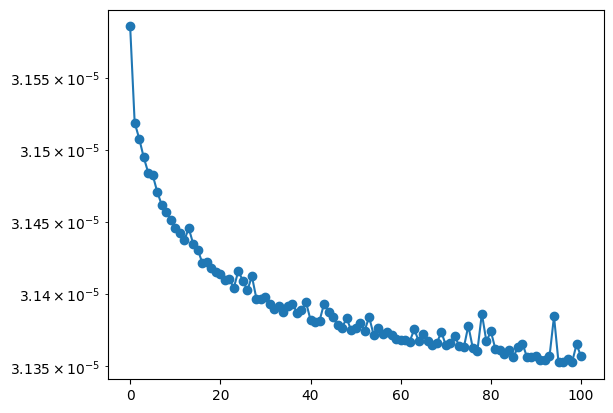

In [ ]:
# np.random.seed(2)
# p_res = np.random.normal(size=(n_sp*(n_sp+1)))
p_res = np.concatenate((reg.intercept_, reg.coef_.flatten()))
# p_res = np.random.normal(0, 1, p.shape[0])*0
# p_res = p.copy()
# p_res = np.concatenate((reg.intercept_, np.zeros(n_sp*n_sp)))

# alpha = 1e-1
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p_res)

n_dt_pred = 10

alpha = 1e-3
adam_t = 1
m = np.zeros_like(p_res)
v = np.zeros_like(p_res)
b1 = 0.9
b2 = 0.999
# eps = 1e-8

mse_hist = [mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred))]
p_hist = []

for i in range(100):
    p_res, Eg2 = minibatch_sgd_rmsprop(x_hist, t_hist, p_res, n_dt_pred, alpha, gamma, eps, Eg2, 10, 1)
    # m *= 0.
    # v *= 0.
    # p_res, m, v, adam_t = minibatch_sgd_adam(x_hist, t_hist, p_res, n_dt_pred, m, v, alpha=alpha, n_it=10, batch_size=1, adam_t=adam_t)
    # m /= 1-b1**adam_t
    # v /= 1-b2**adam_t
    # adam_t += 1
    mse_hist.append(mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred)))
    p_hist.append(p_res.copy())

plt.plot(mse_hist, "-o")
plt.yscale("log")
plt.show()

In [ ]:
print((np.sign(p[n_sp:])==np.sign(reg.coef_.flatten())).mean())
print((np.sign(p[n_sp:])==np.sign(p_res[n_sp:])).mean())

0.56
0.56


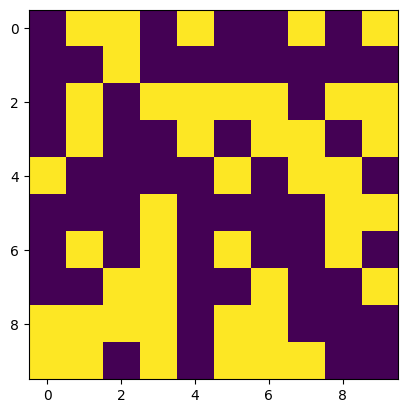

In [ ]:
plt.imshow(np.sign(p[n_sp:].reshape((n_sp,n_sp))))

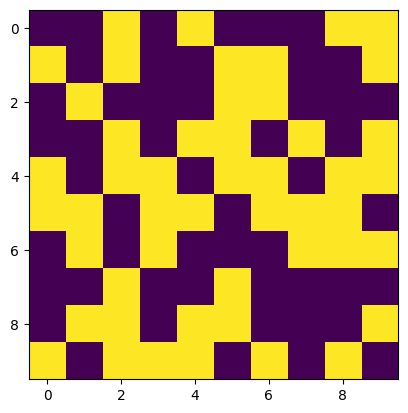

In [ ]:
plt.imshow(np.sign(reg.coef_))

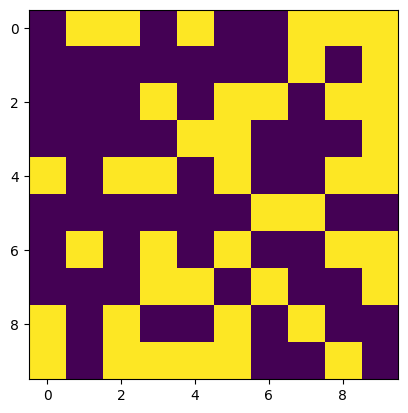

In [ ]:
plt.imshow(np.sign(p_res[n_sp:].reshape((n_sp,n_sp))))